In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from external_flux import *

In [3]:
import glob
import re
from astropy.io import fits

# External

In [4]:
t_goes, f_goes = read_flux_external(sorted(glob.glob('../datasets/external/GOES/GOES_20*.txt')))
t_goes = t_goes.mjd

t_ace, f_ace = read_flux_external(sorted(glob.glob('../datasets/external/ACE/ACE_20*.txt')))
t_ace = t_ace.mjd

# Spin-turns

In [5]:
from astropy.io import fits

spinturns = fits.getdata('../datasets/Spinphase/SpinTurns.fits')["TIME"]

# Fluxes in SM

In [7]:
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat')
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV2_ROW1.dat')
inarr = fits.getdata('../output/Fluxes/FLUX_SM-PPE.fits',extname='ROW_1FOV_1')
t_P = inarr["TIME"]
f_P = inarr["FLUX"]
err_P = inarr["FLUX_ERR"]

In [8]:
t_P

array([ 56661.72265625,  56661.7265625 ,  56661.73046875, ...,
        58126.86328125,  58126.8671875 ,  58126.8671875 ], dtype=float32)

In [11]:
#(t_S,n_S,f_S,err_S) = fits_flux(allpaths)

# for SM: load flux for every chip at once
t_S = []
f_S = []
err_S = []

hdulist = fits.open('../output/Fluxes/FLUX_SM-SIF.fits')

for h in hdulist[1:]:
    t_S += list(h.data["TIME"])
    f_S += list(h.data["FLUX"])
    err_S += list(h.data["FLUX_ERR"])
        
hdulist.close()

# then sort by time
sorter = sorted((zip(t_S,f_S,err_S)),key = lambda x: x[0])

t_S = np.array([s[0] for s in sorter])
f_S = np.array([s[1] for s in sorter])
err_S = np.array([s[2] for s in sorter])

# BAM

In [14]:
inarr = fits.getdata('../output/Fluxes/FLUX_BAM-OBS.fits',1)

t_B1_full = inarr["TIME"]
f_B1_full = inarr["FLUX"]
err_B1_full = inarr["FLUX_ERR"]

In [15]:
inarr = fits.getdata('../output/Fluxes/FLUX_BAM-SIF.fits',1)

t_BS1 = inarr["TIME"]
f_BS1 = inarr["FLUX"]
err_BS1 = inarr["FLUX_ERR"]

In [11]:
l = fits.open('../output/Fluxes/FLUX_BAM-SIF.fits')

In [13]:
[h.name for h in l]

['PRIMARY', 'ROW1_FOV1', 'ROW1_FOV2']

In [19]:
def rebin_fluxes(arrs,binning):
    """
    Rebin time,fluxes and flux errors by averaging over 'binning' samples
    flux errors (the third tuple element) uses error propagation
    """
    
    if binning==1:
        return arrs
    
    out = []
    
    for ii in range(len(arrs)):
        len_rebin = len(arrs[ii])//binning  # integer division! 
                                            # we want to round down, so we ignore the last up to binning-1 samples
        a_rebin = np.reshape(arrs[ii][:len_rebin*binning], (len_rebin,binning))
        
        if ii==2:
            a_rebin = np.sqrt(np.sum(a_rebin**2,axis=1))/binning
        else:
            a_rebin = np.mean(a_rebin,axis=1)
        
        out.append(a_rebin)

    return tuple(out)

In [20]:
rebin_fac = 10

t_B1,f_B1,err_B1 = rebin_fluxes((t_B1_full,f_B1_full,err_B1_full), rebin_fac)

In [21]:
def MJD_cutout(t,f,err,mjd_start,mjd_stop,stepping=1):
    """
    Return time [mjd], flux and error within a certain inclusive range of mjd.
    By setting stepping=n, this will only return every nth sample
    """
    retrange = np.logical_and(t>=mjd_start, t<=mjd_stop)
    
    if stepping < 1:
        stepping = 1
    
    return t[retrange][::stepping], f[retrange][::stepping], err[retrange][::stepping]

In [22]:
def flareplot(tstart,tstop,stepping,ybam=(1,100),ysm=(1,100),yext=(.05,500),log=True,turns=None):
    t1,f1,err1 = MJD_cutout(t_B1,f_B1,err_B1,tstart,tstop,stepping)
    t2,f2,err2 = MJD_cutout(t_BS1,f_BS1,err_BS1,tstart,tstop,1)
    t3,f3,err3 = MJD_cutout(t_P,f_P,err_P,   tstart,tstop,stepping)
    t4,f4,err4 = MJD_cutout(t_S,f_S,err_S,   tstart,tstop,1)

    fig, (axbam, axsm, axext) = plt.subplots(nrows=3,sharex=True)
    
    axbam.errorbar(t1, f1, yerr=err1*0, linestyle='', marker='x', color='xkcd:red', label="BAM-OBS1")
    if len(t2>0):
        axbam.errorbar(t2, f2, yerr=err2*0, linestyle='', marker='x', color='xkcd:faded blue', label="BAM-SIF1")
    
    if len(t4>0):
        axsm.errorbar(t4, f4, yerr=err4, linestyle='', marker='x', color='xkcd:tree green', label="SM-SIF")
    axsm.errorbar(t3, f3, yerr=err3, linestyle='', marker='x', color='xkcd:amethyst', label="SM-PPE")
    
    #axext.plot(t_goes[::30], f_goes[2][::30], linestyle='', marker='x', color='xkcd:amethyst', label="GOES > 10 MeV")
    axext.plot(t_ace, f_ace[0], linestyle='', marker='x', color='xkcd:red', label="ACE > 10 MeV")
    axext.plot(t_ace, f_ace[1], linestyle='', marker='x', color='xkcd:faded blue', label="ACE > 30 MeV")
    
    # if available: mark the points where gaia does a full revolution
    if not (turns is None):
        axbam.plot(turns,np.ones(turns.shape)*ybam[0], linestyle='', marker='d',color='k')
        axsm.plot(turns,np.ones(turns.shape)*ysm[0], linestyle='', marker='d',color='k')

    # logarithmic axes
    if log==True:
        axbam.set_yscale('log')
        axsm.set_yscale('log')
        axext.set_yscale('log')
    
    axbam.legend(loc='upper right')
    axsm.legend(loc='upper right')
    axext.legend(loc='upper right')

    axbam.set_ylim(ybam)
    axbam.set_ylabel("Flux [particles/s/cm^2]")

    axsm.set_ylim(ysm)
    axsm.set_ylabel("Flux [particles/s/cm^2]")

    axext.set_ylim(yext)
    axext.set_ylabel("Flux [particles/sr/s/cm^2]")
    axext.set_xlabel("MJD")

    axbam.set_xlim(tstart,tstop)

    plt.gcf().set_size_inches(20,10)

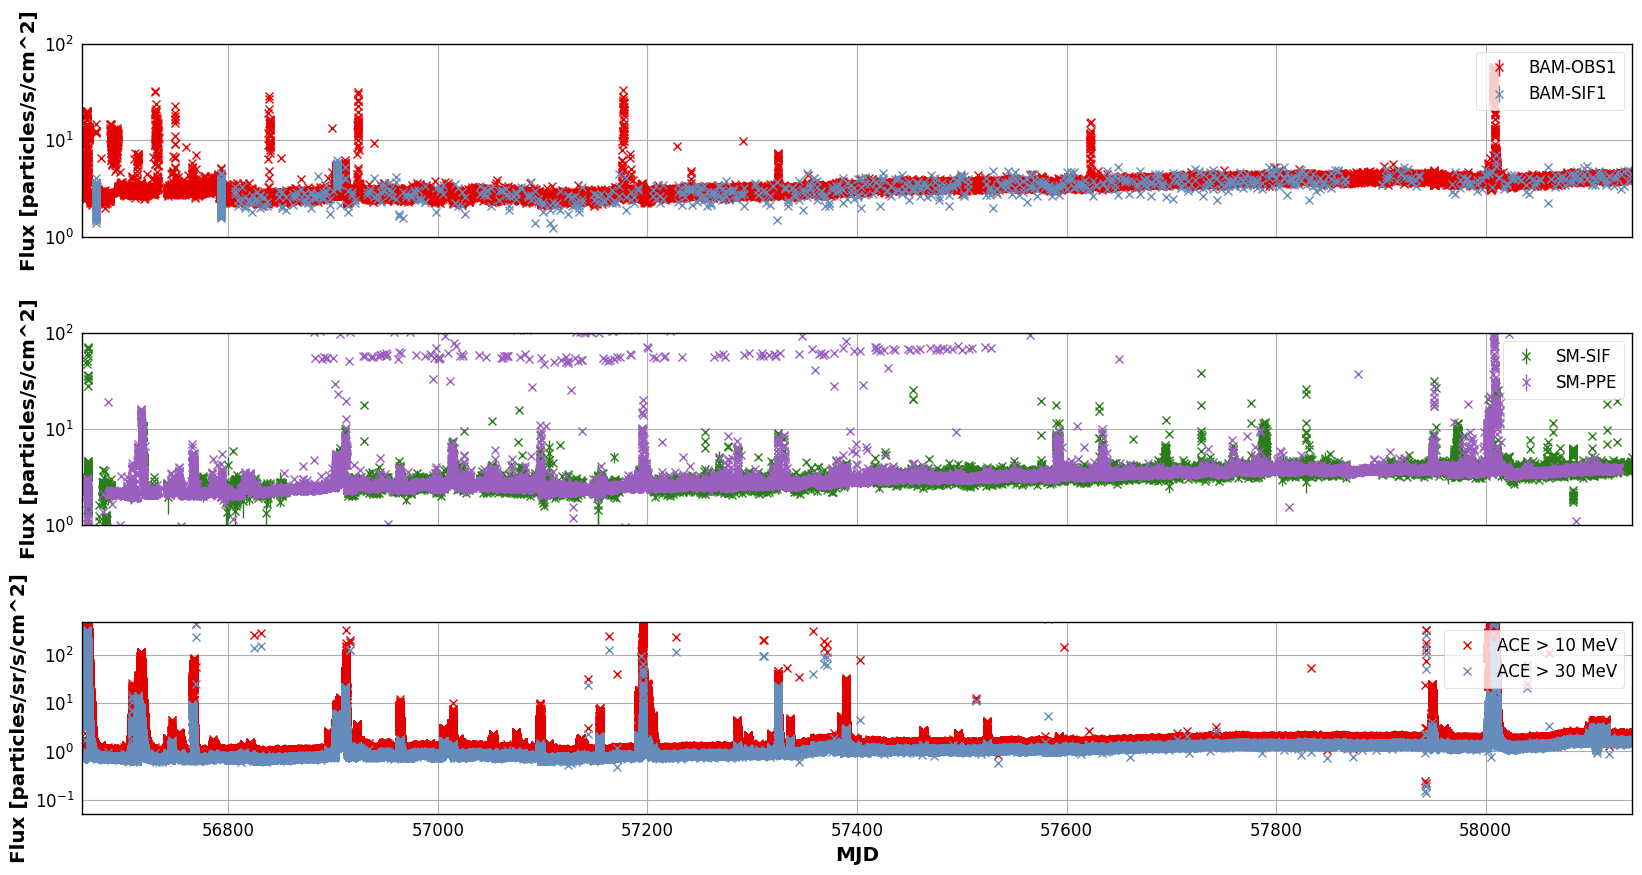

In [28]:
#tstart,tstop  = (57150,57200)
#tstart,tstop  = (58000,58015) # Sept '17 Flare
#tstart,tstop = (57945,57955)  # Jul '17 Flare
#tstart,tstop = (56901,56915) # Sept '14
#tstart,tstop = (56880,57050)
#tstart,tstop = (57930,57945) # quiet period
#tstart,tstop = (57632,57636) # strong stray light modulation

#otimes = [OBMT_apyTime(t).mjd for t in t_S]

flareplot(min(t_S),max(t_S),10)

Let's look at a few individual flares

We'll look at periods of 200 days and then zoom in on whatever we find

## Beginning - 56800

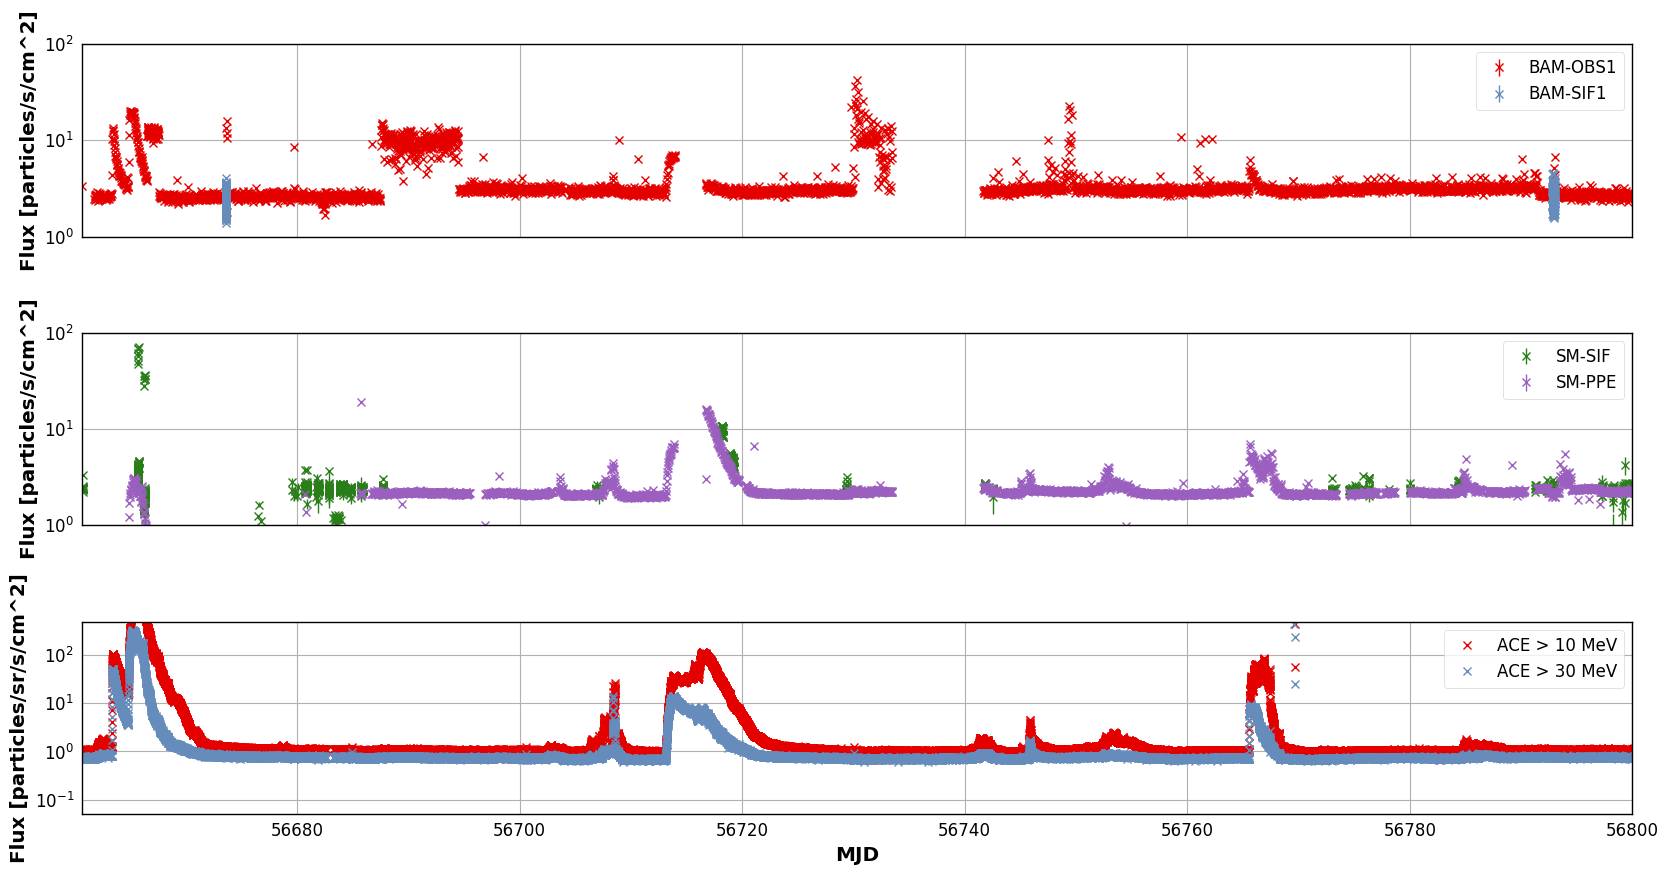

In [30]:
flareplot(min(t_B1),56800,10)

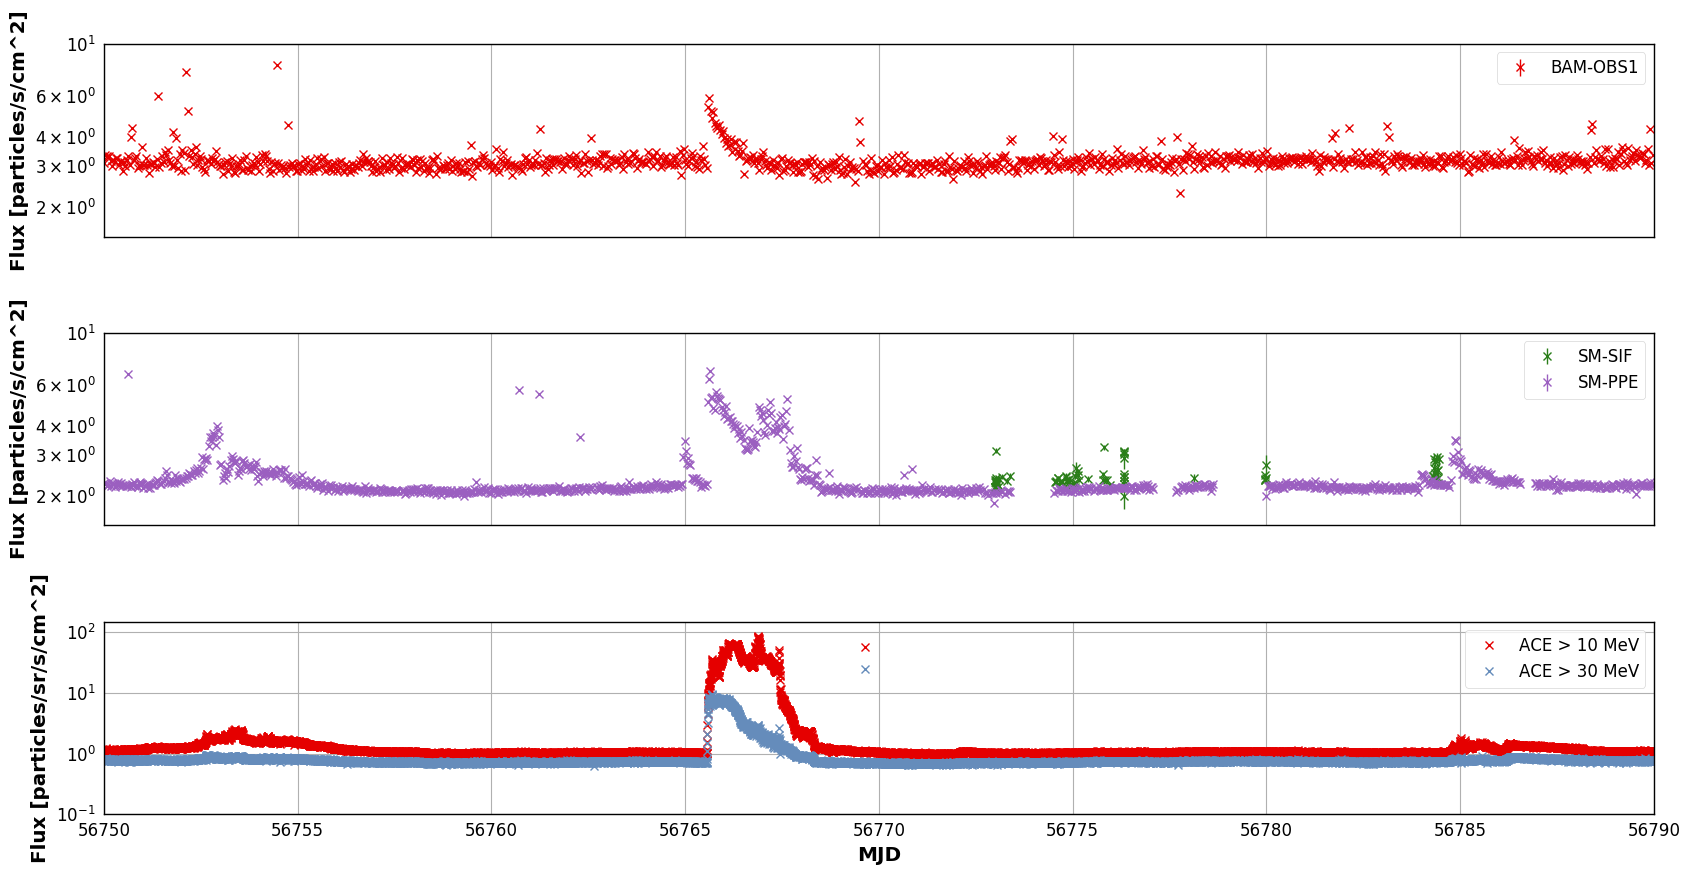

In [68]:
flareplot(56750,56790,10,ybam=(1.5,10),ysm=(1.5,10),yext=(.1,150))

Good demonstratio of BAM vs SM in regards to energy. Interesting dip in the middle of SM?

## 56800 - 57000

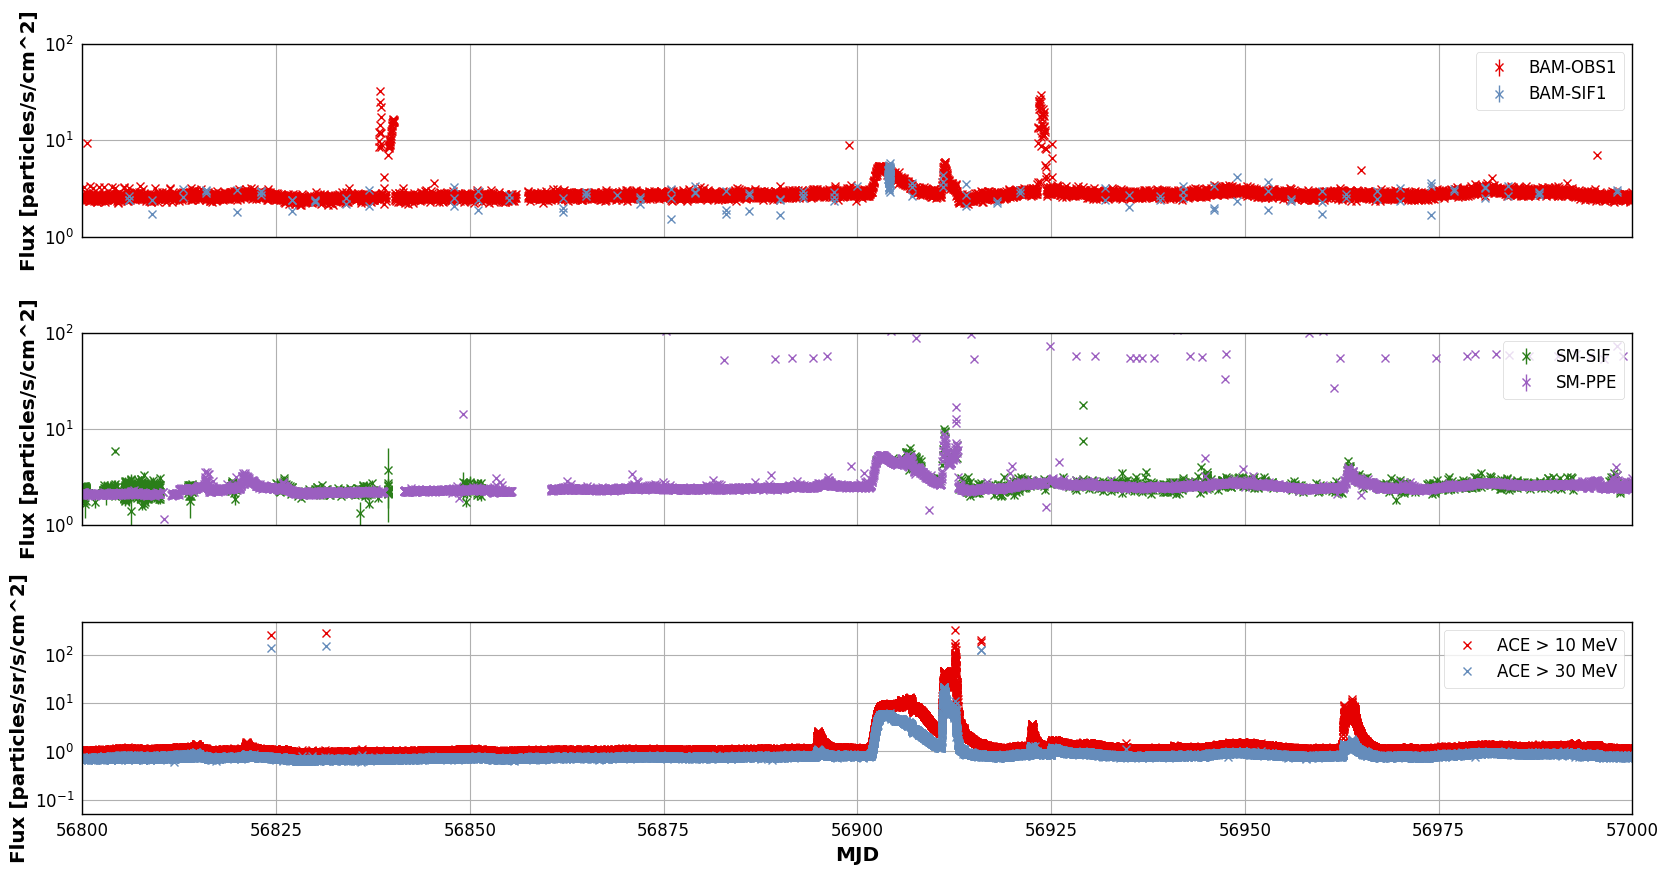

In [69]:
flareplot(56800,57000,10)

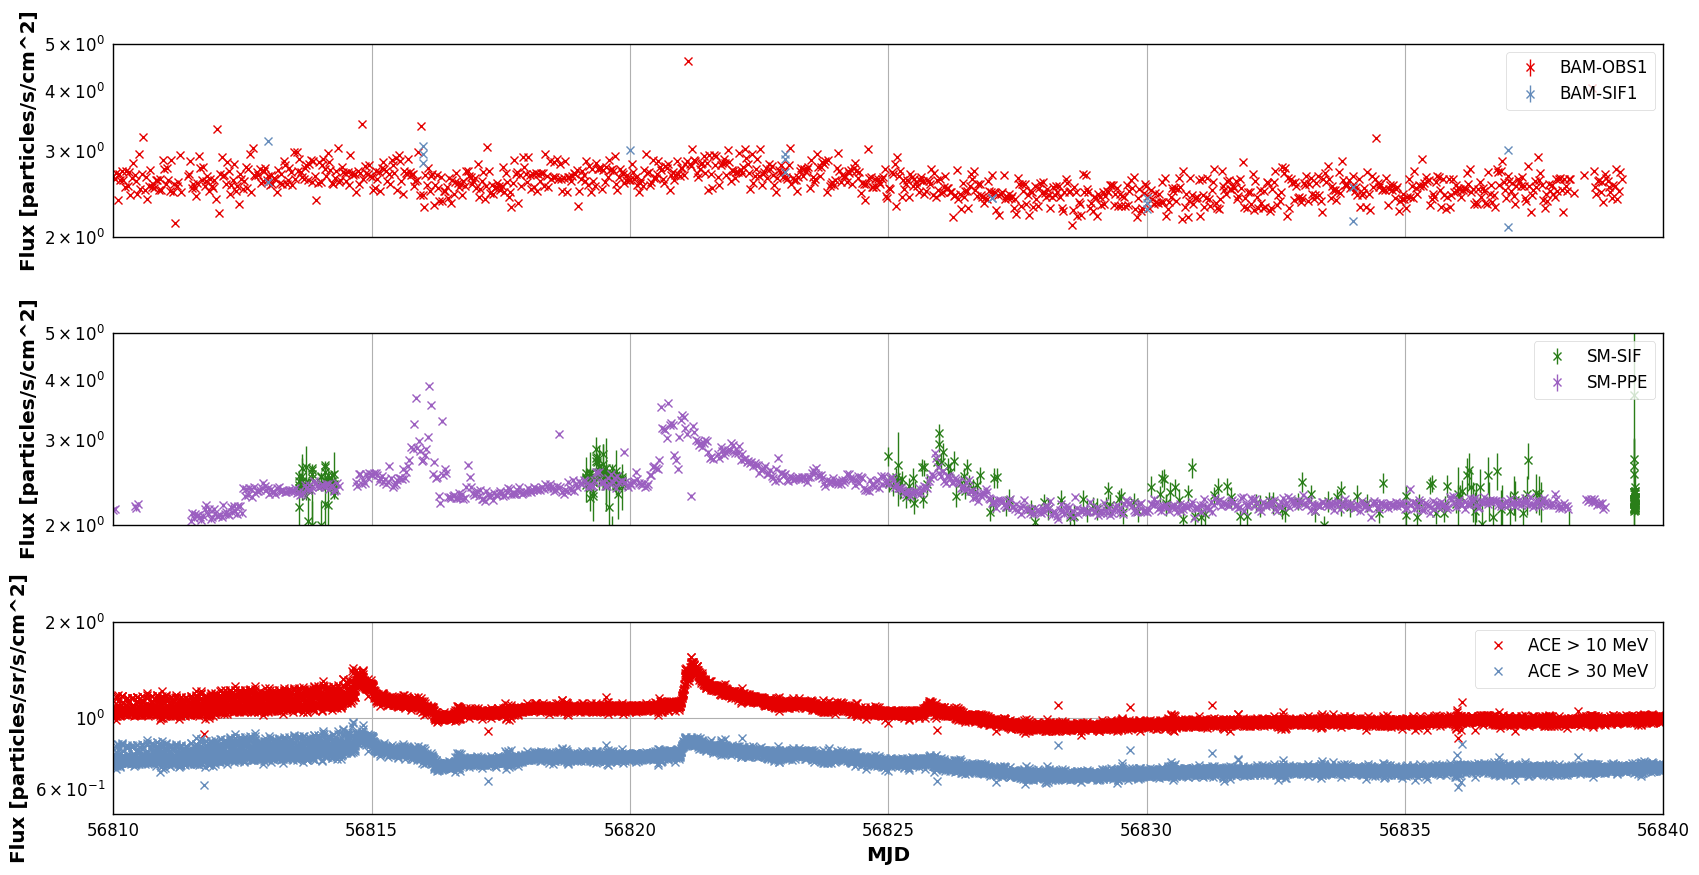

In [70]:
flareplot(56810,56840,10,ybam=(2,5),ysm=(2,5),yext=(.5,2),log=True)

There seem to be some arrival time delays here?

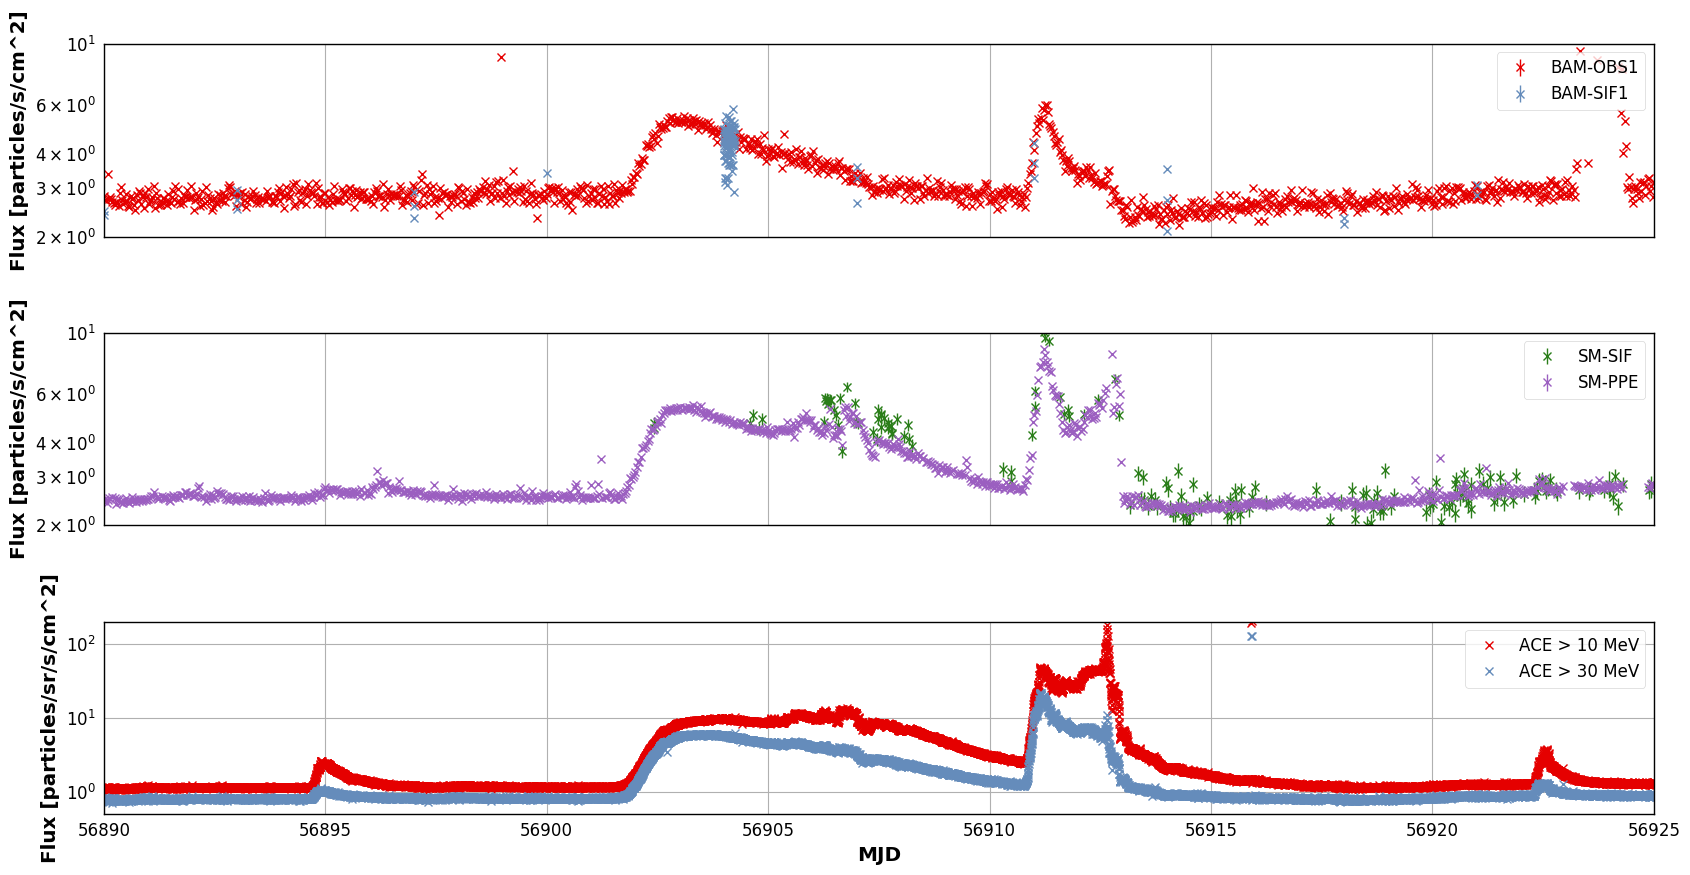

In [71]:
flareplot(56890,56925,10,ybam=(2,10),ysm=(2,10),yext=(.5,200))

Nice how SM also sees a 'wiggle' in the precursor. The double-peaked thing sould be interesting to study.

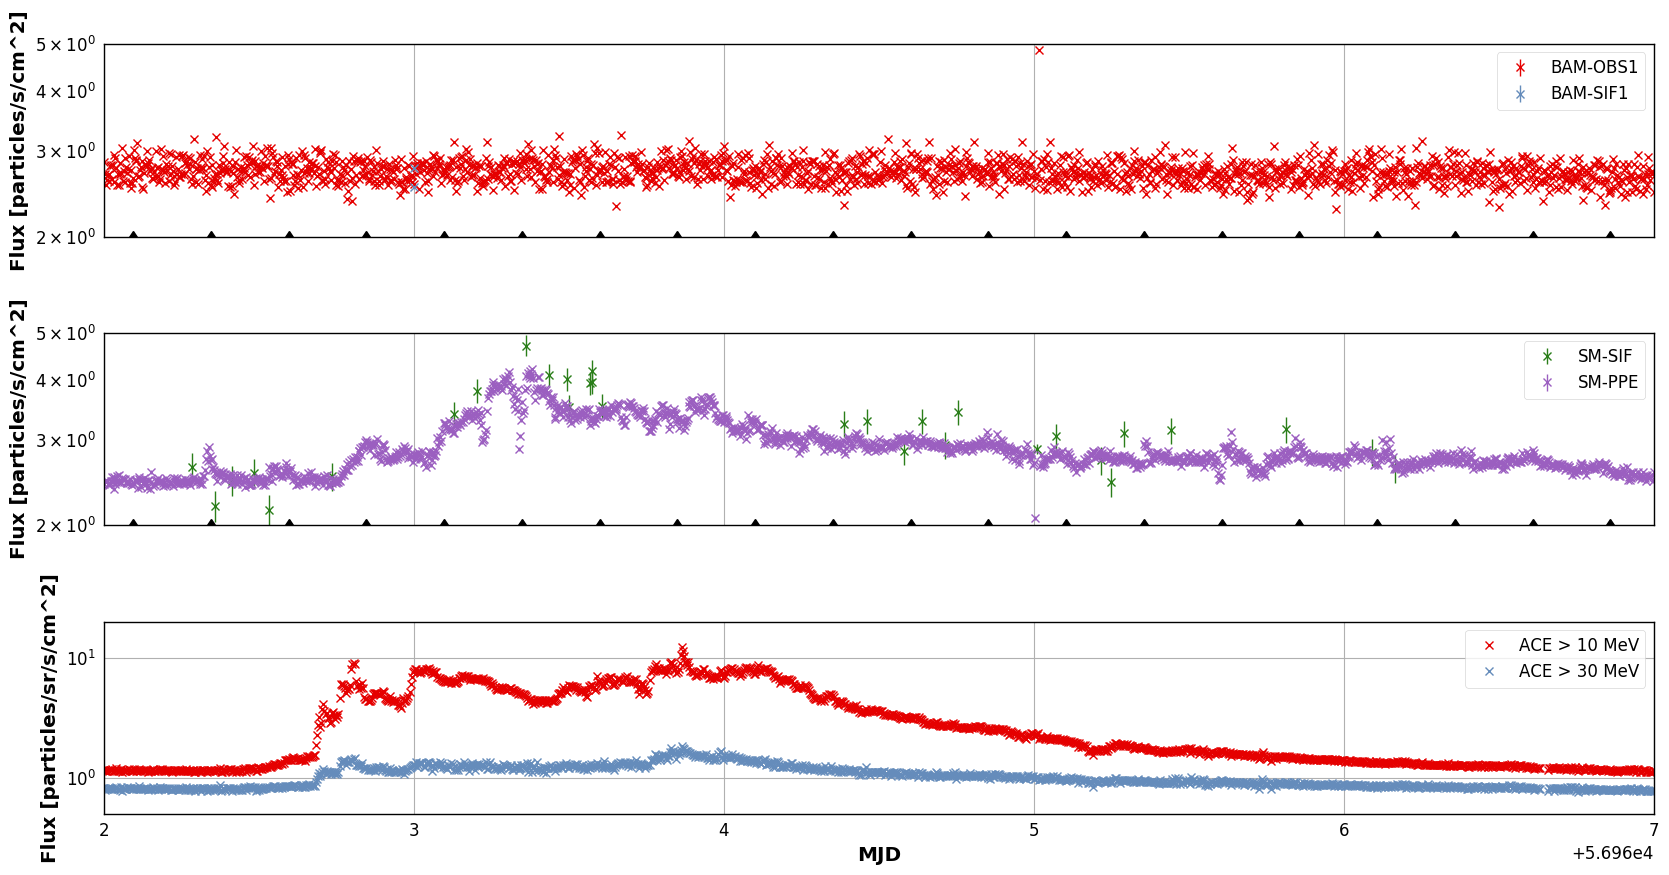

In [72]:
flareplot(56962,56967,1,ybam=(2,5),ysm=(2,5),yext=(.5,20),log=True,turns=spinturns)

This also looks like there's some different timing, no?

## 57000 - 57200

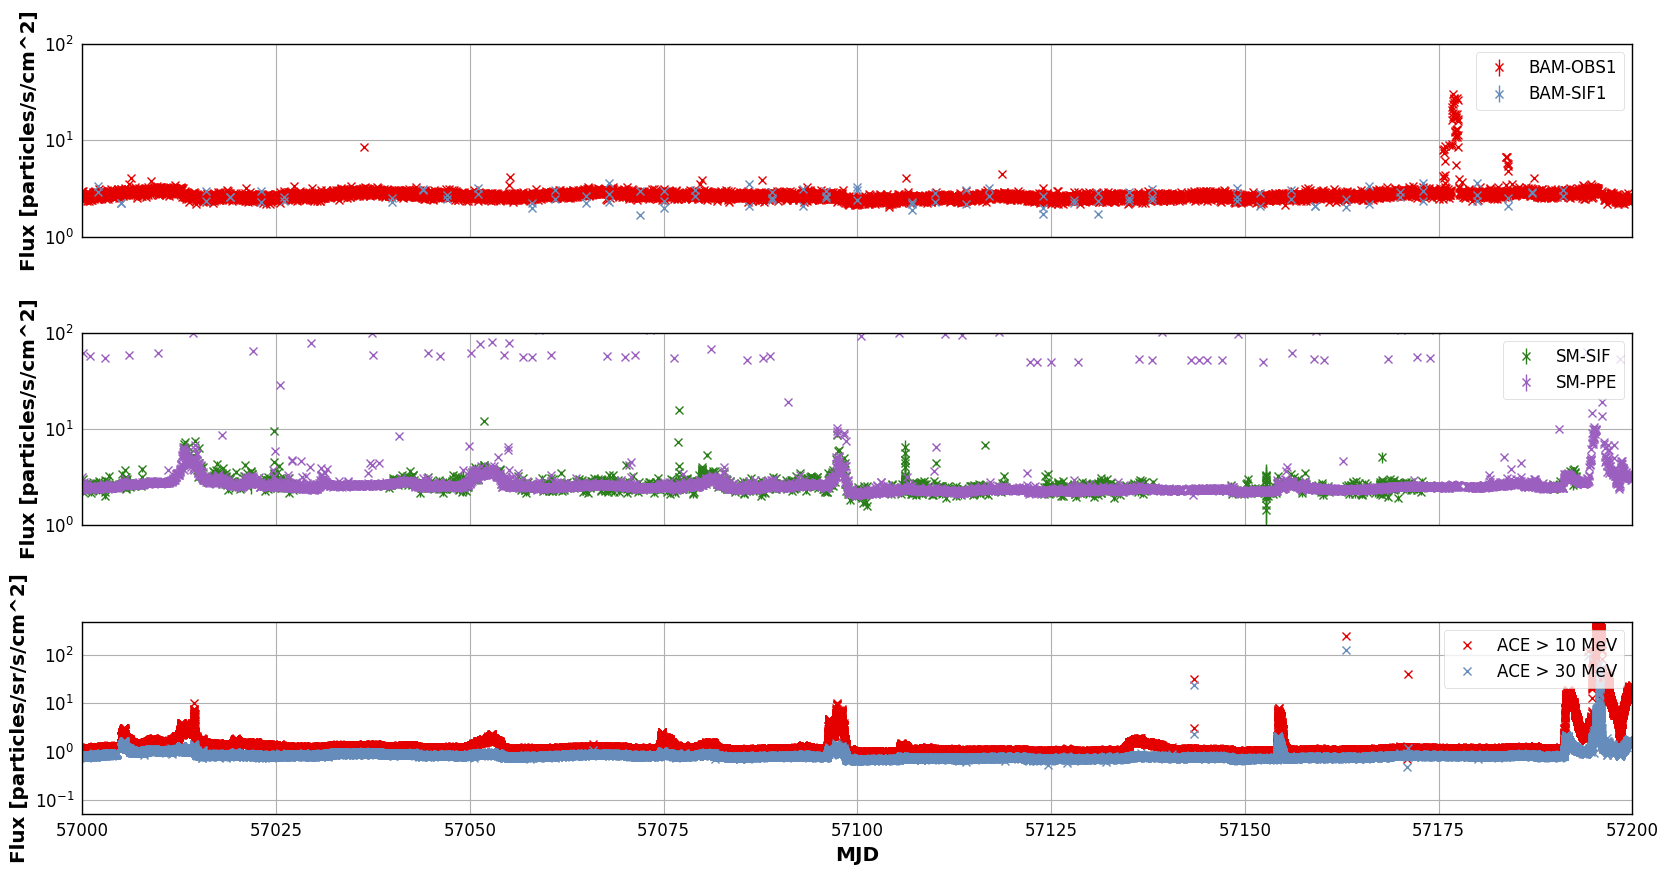

In [73]:
flareplot(57000,57200,10)

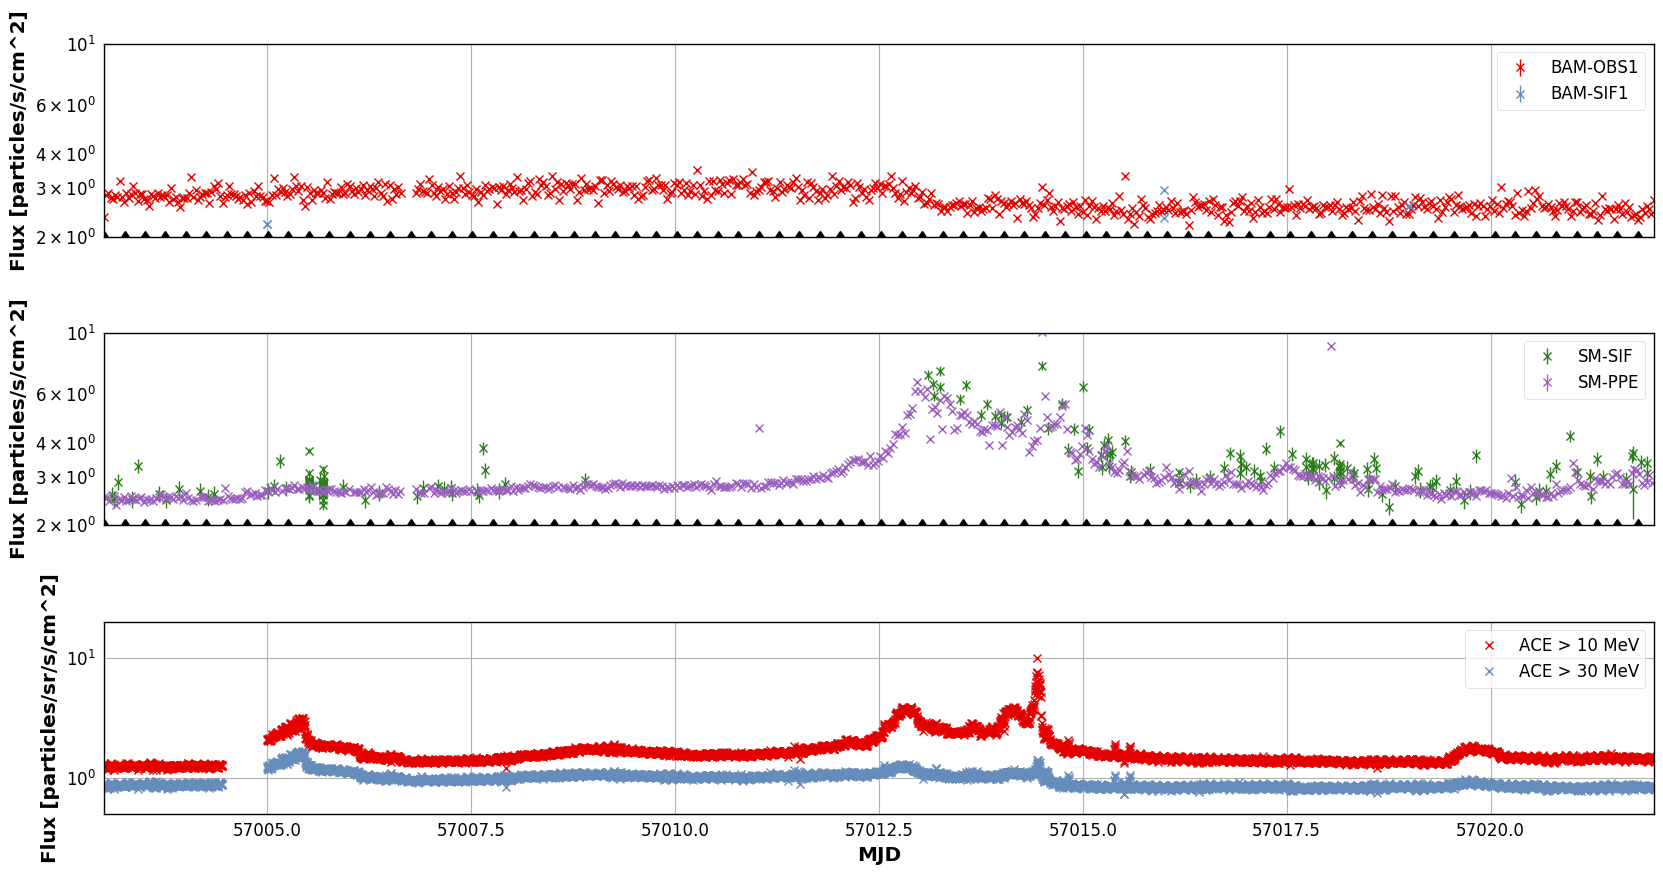

In [74]:
flareplot(57003,57022,10,ybam=(2,10),ysm=(2,10),yext=(.5,20),turns=spinturns)

Flare around 57005 is not picked up at all?

BAM actually does see some flaring, although the point at which the countrates go down is strange.

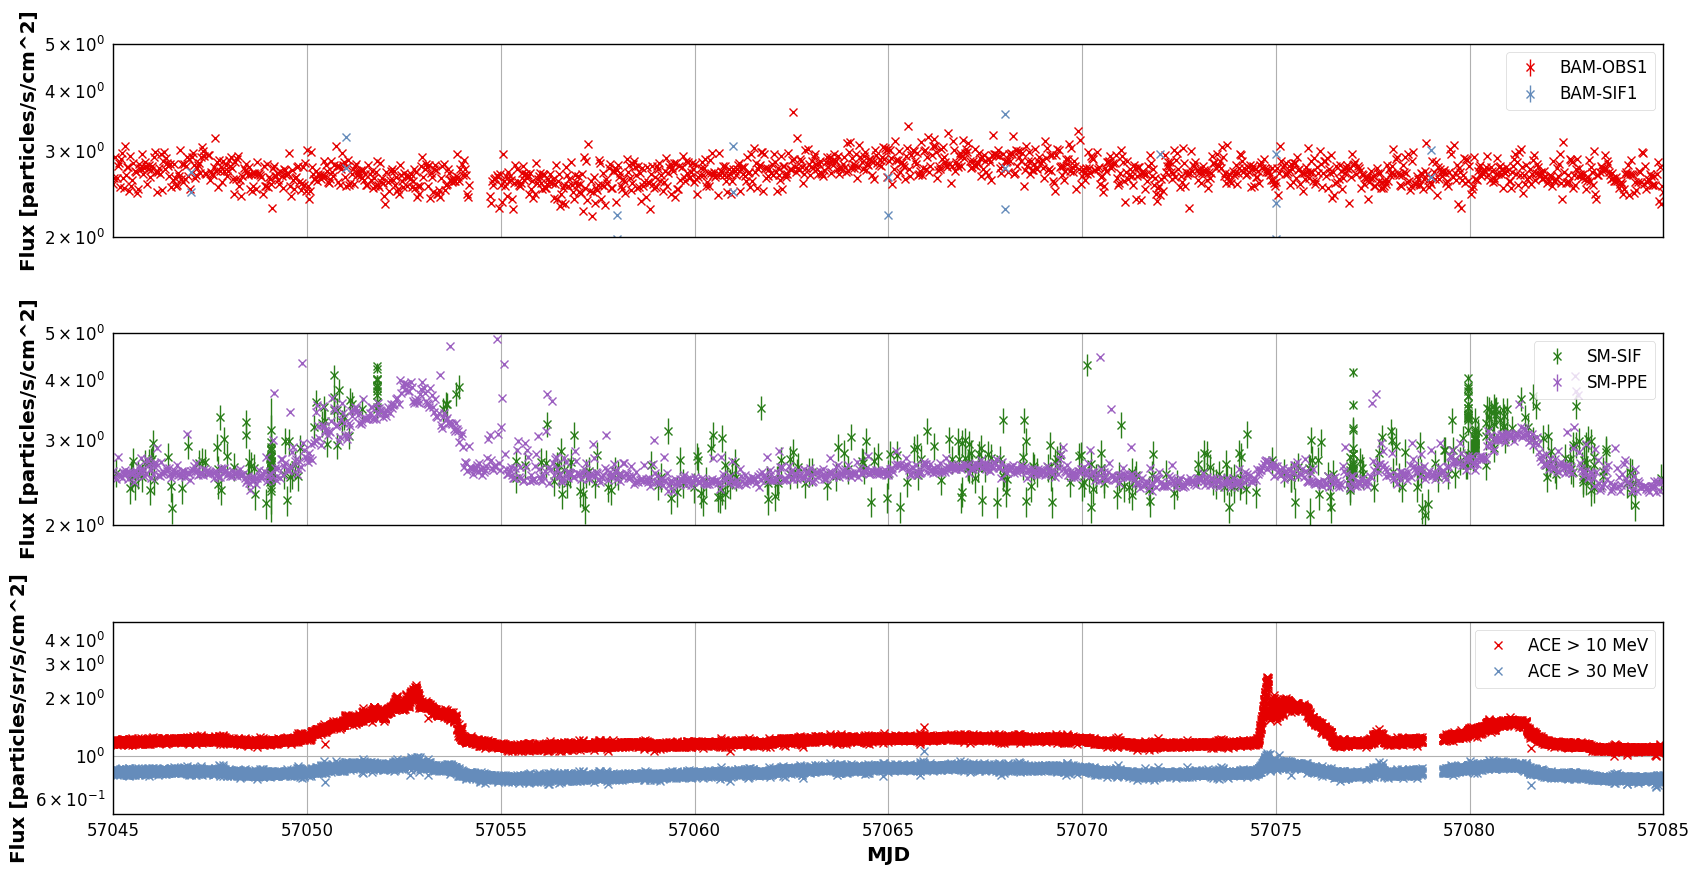

In [75]:
flareplot(57045,57085,10,ybam=(2,5),ysm=(2,5),yext=(.5,5))

The second flare is really interesting - SM vs ACE show different relative peaks.

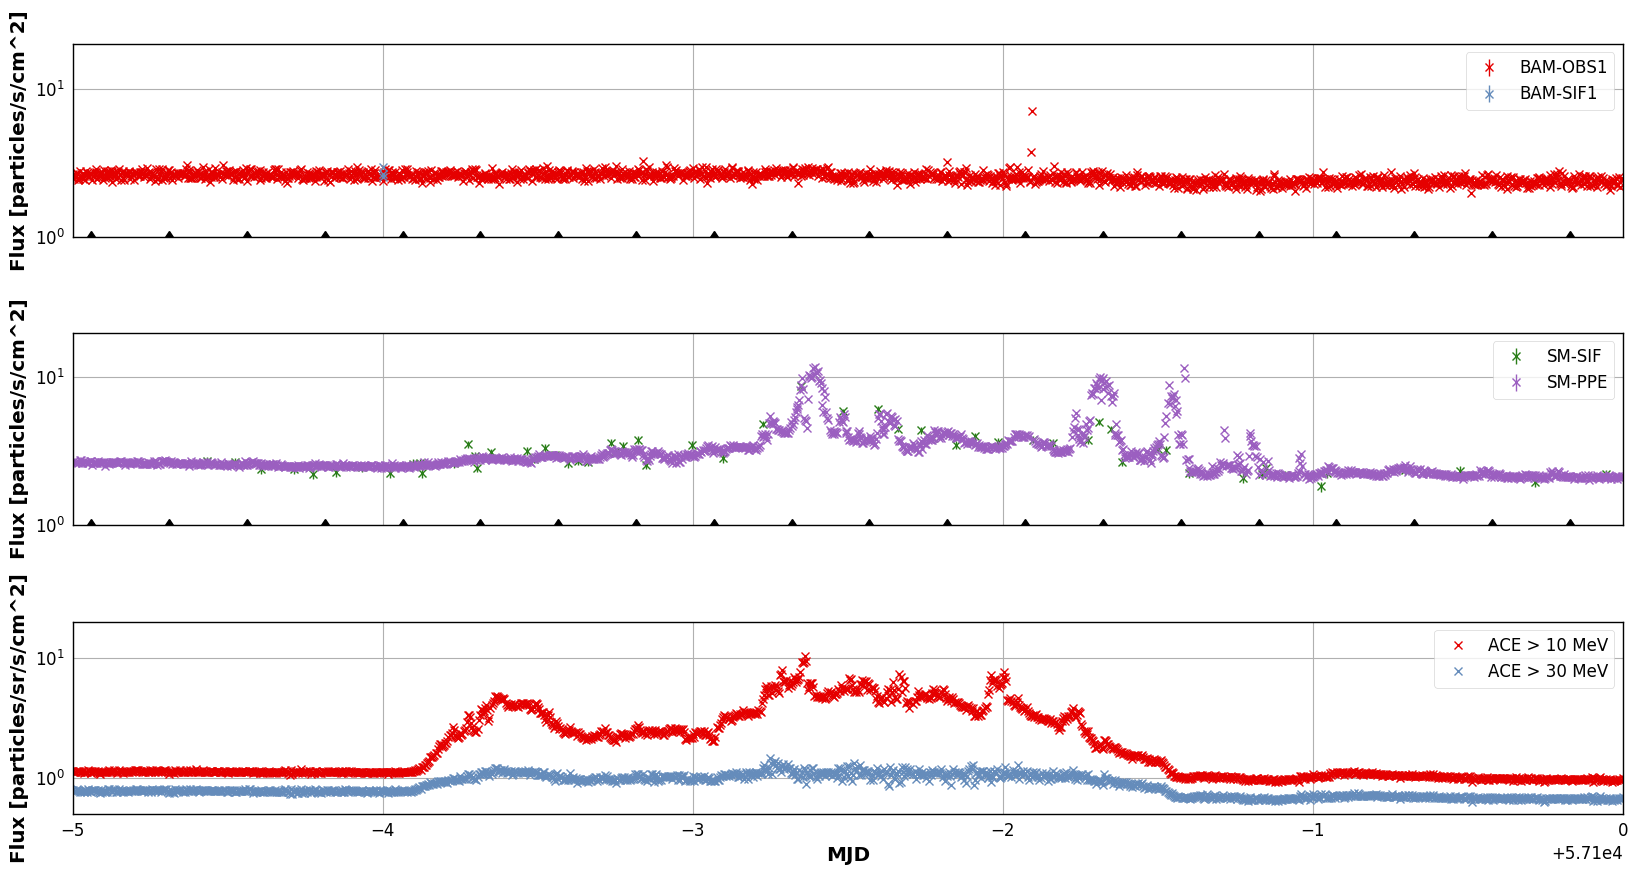

In [76]:
flareplot(57095,57100,1,ybam=(1,20),ysm=(1,20),yext=(.5,20),log=True,turns=spinturns)

Timing difference?

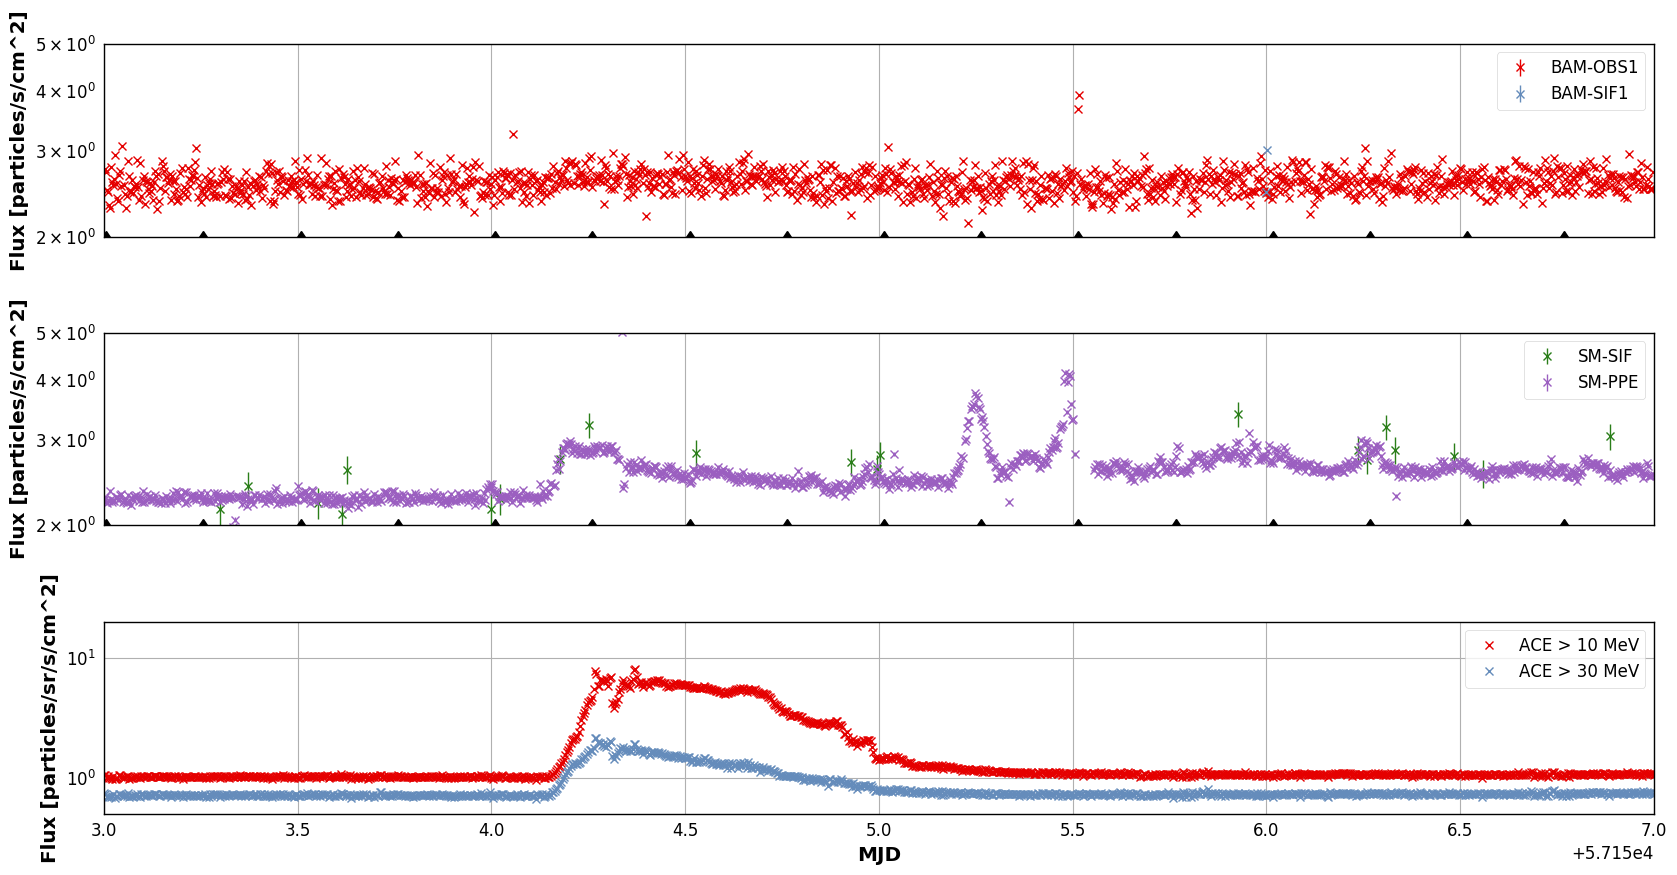

In [77]:
flareplot(57153,57157,1,ybam=(2,5),ysm=(2,5),yext=(.5,20),turns=spinturns)

Strange structure after the flare proper in SM - associated with rotation?

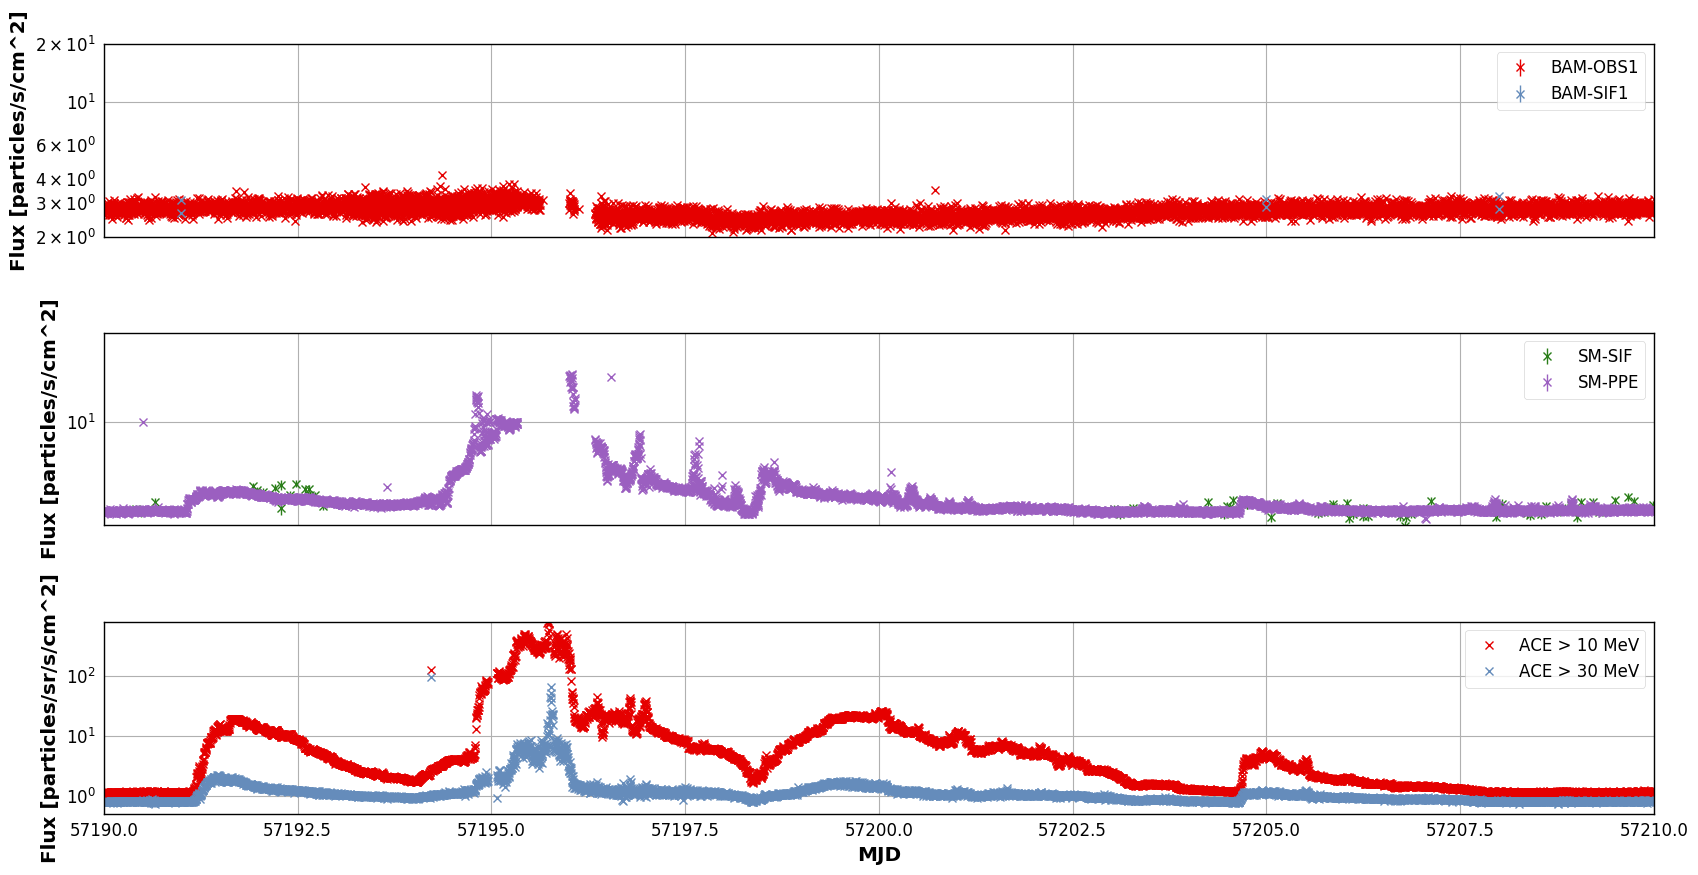

In [78]:
flareplot(57190,57210,1,ybam=(2,20),ysm=(2,40),yext=(.5,800),log=True)

An annoying data gap...

## 57200 - 57400

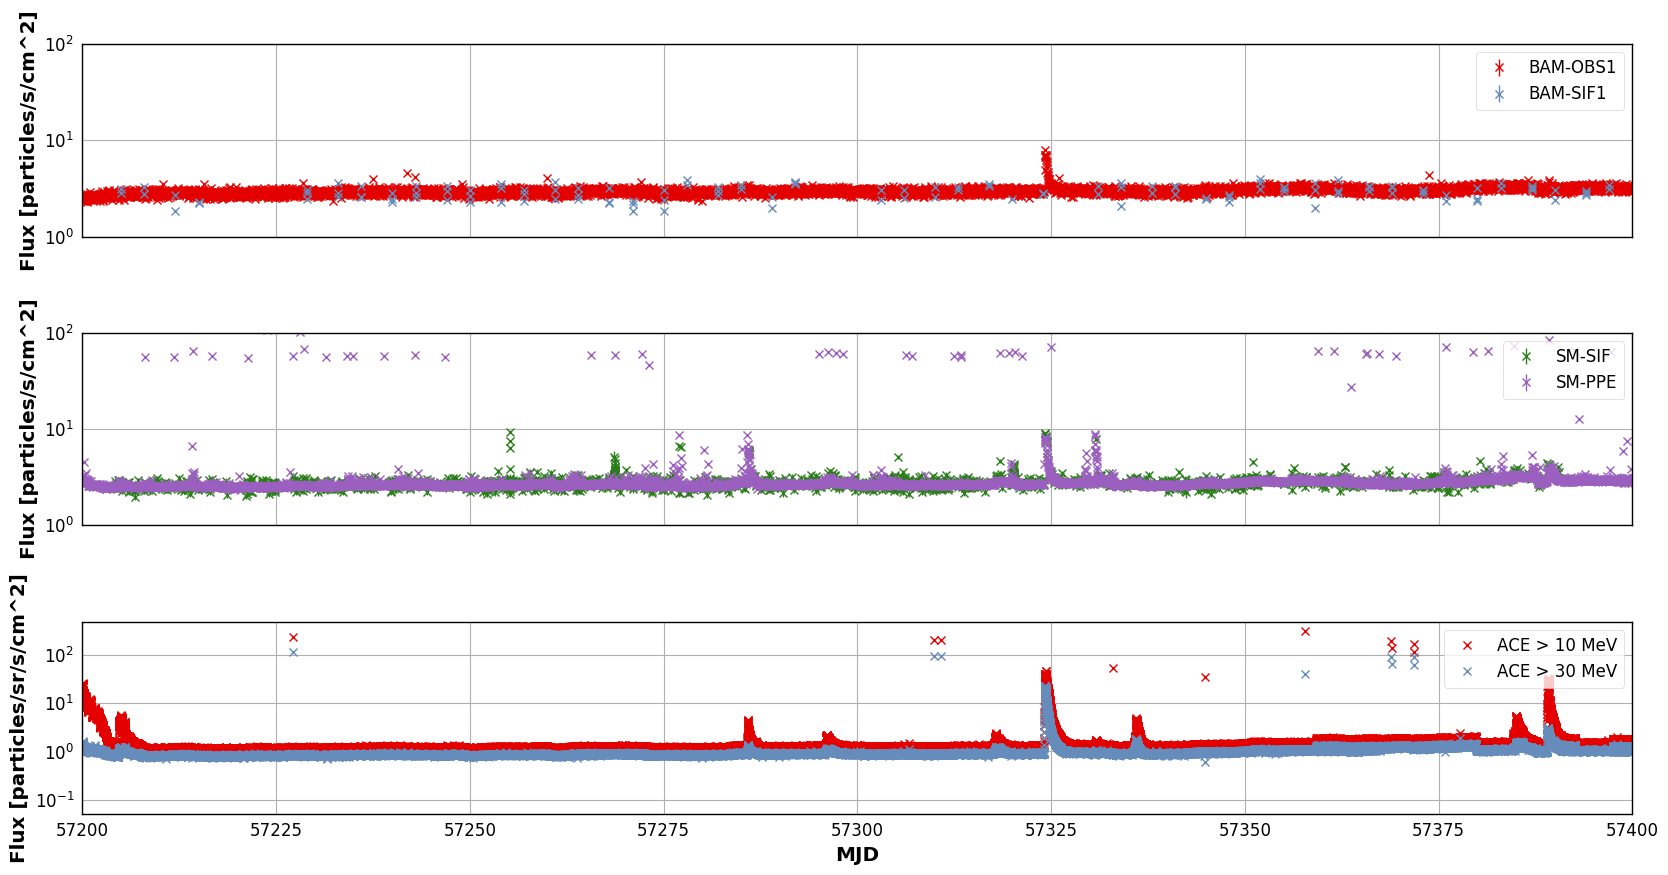

In [79]:
flareplot(57200,57400,10)

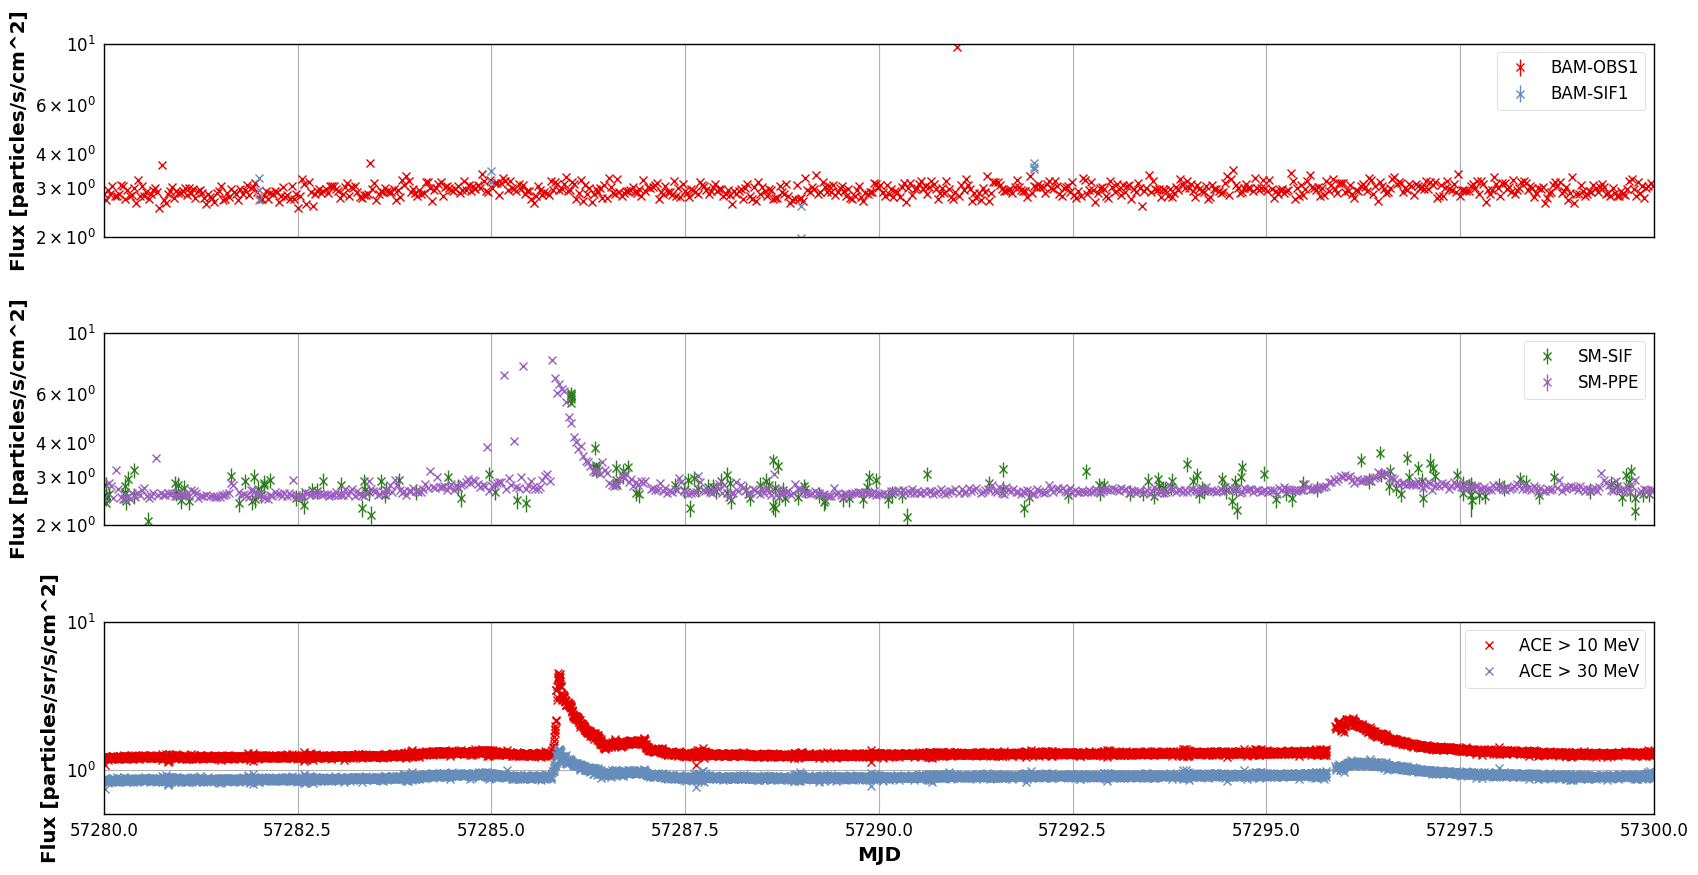

In [80]:
flareplot(57280,57300,10,ybam=(2,10),ysm=(2,10),yext=(.5,10))

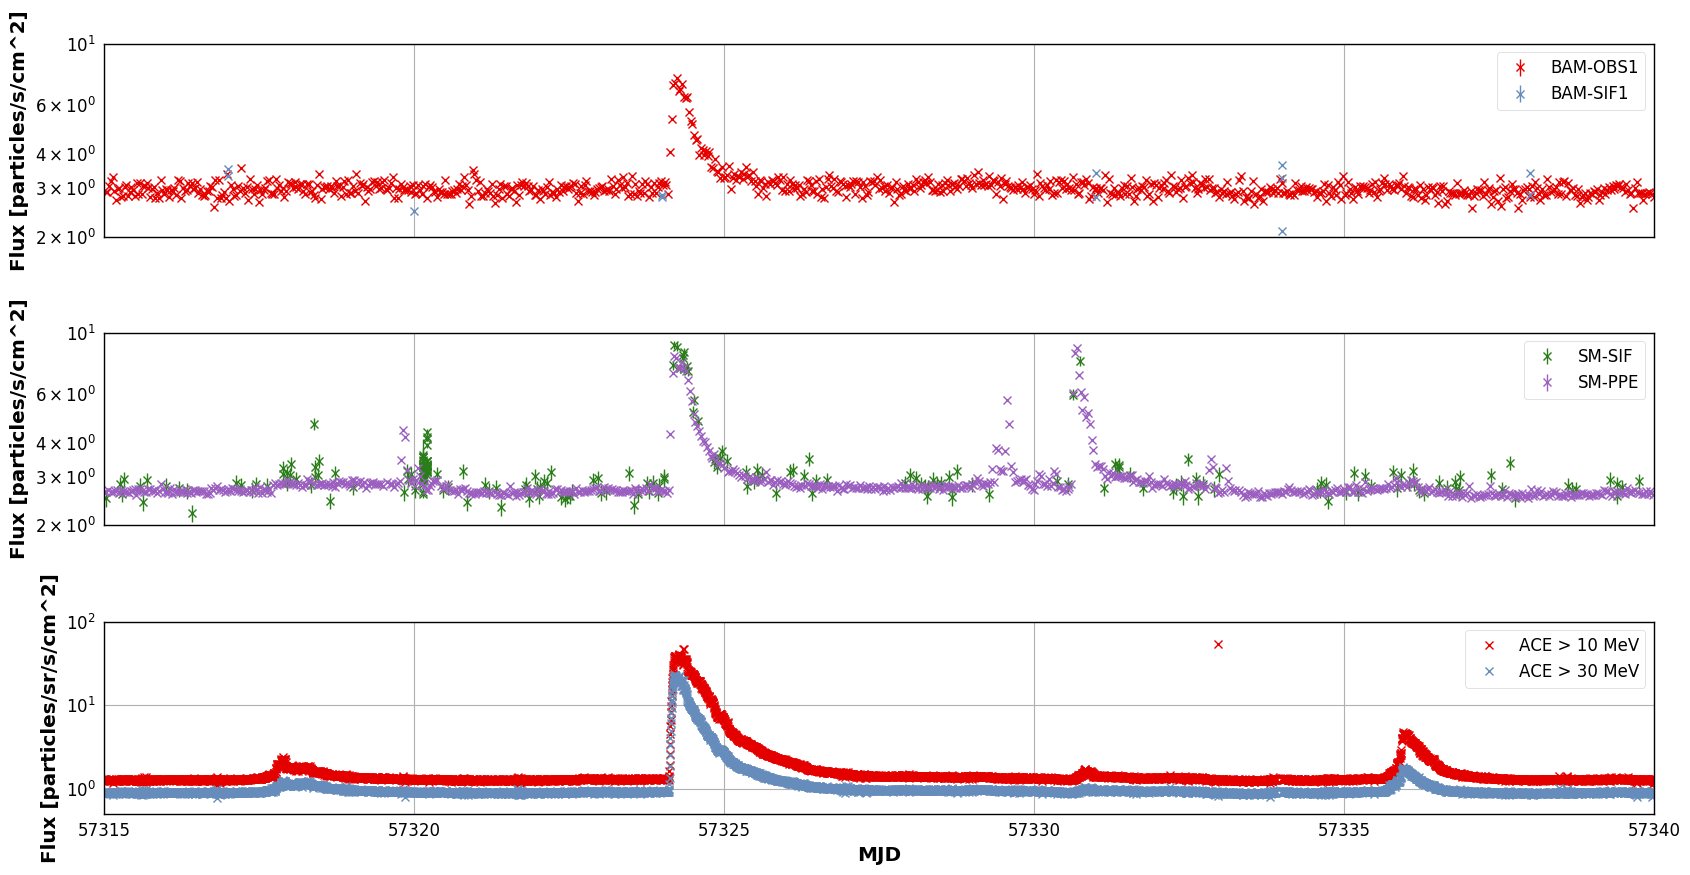

In [81]:
flareplot(57315,57340,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

Very interesting how the first flare is picked up, but the second almost not at all

Is the peak in the middle for SM just some stars?

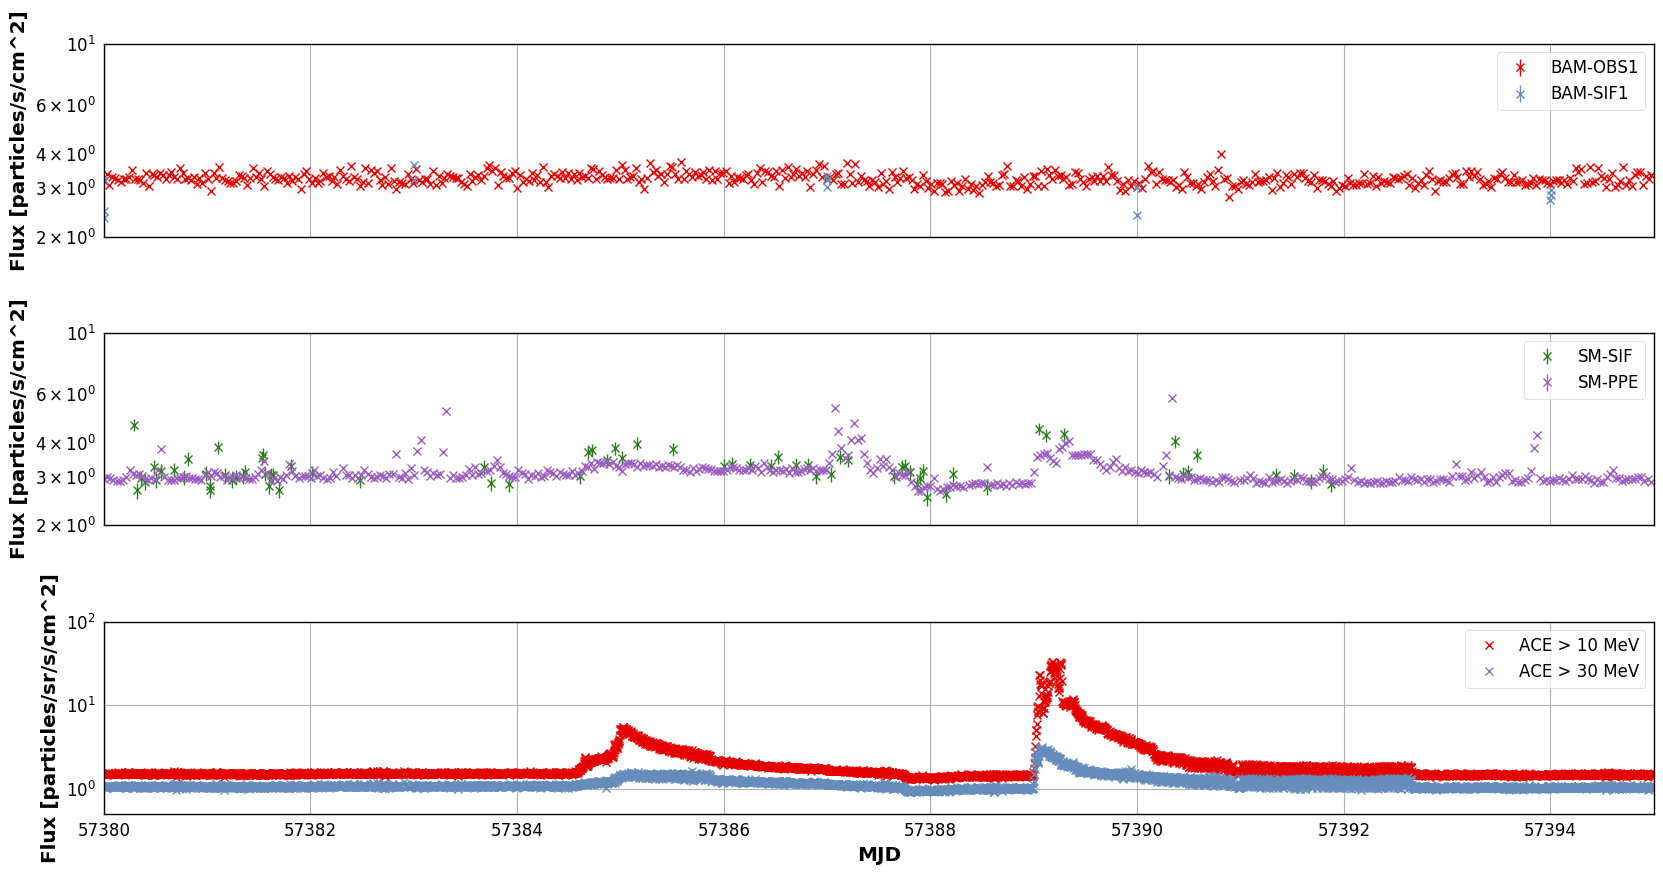

In [82]:
flareplot(57380,57395,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

SM looks weird here

## 57400 - 57600

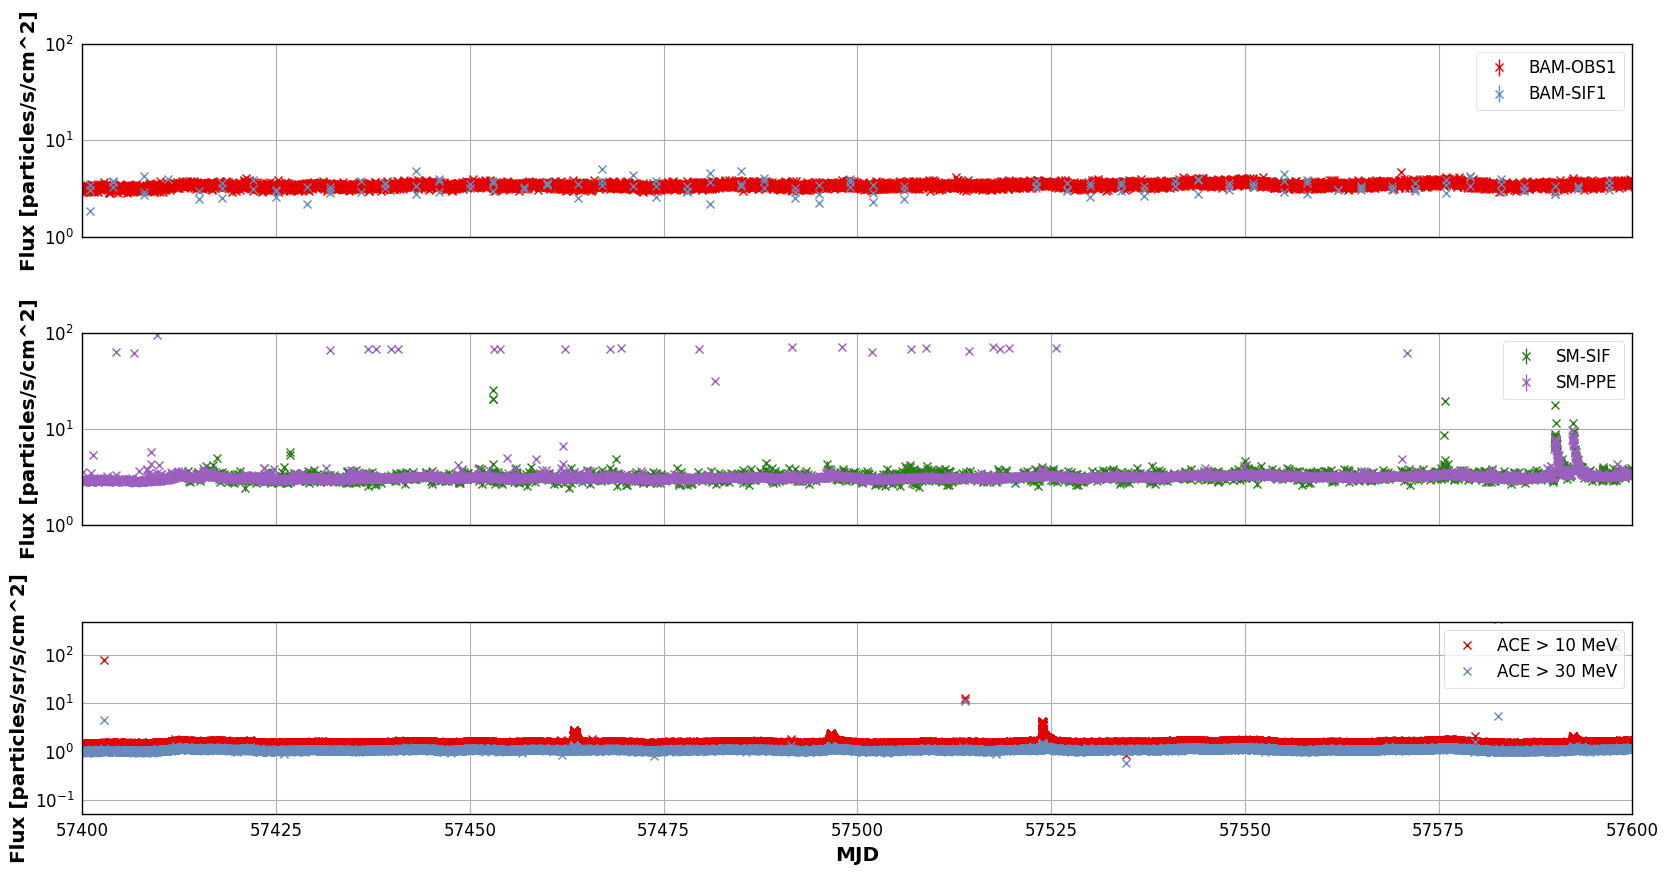

In [83]:
flareplot(57400,57600,10)

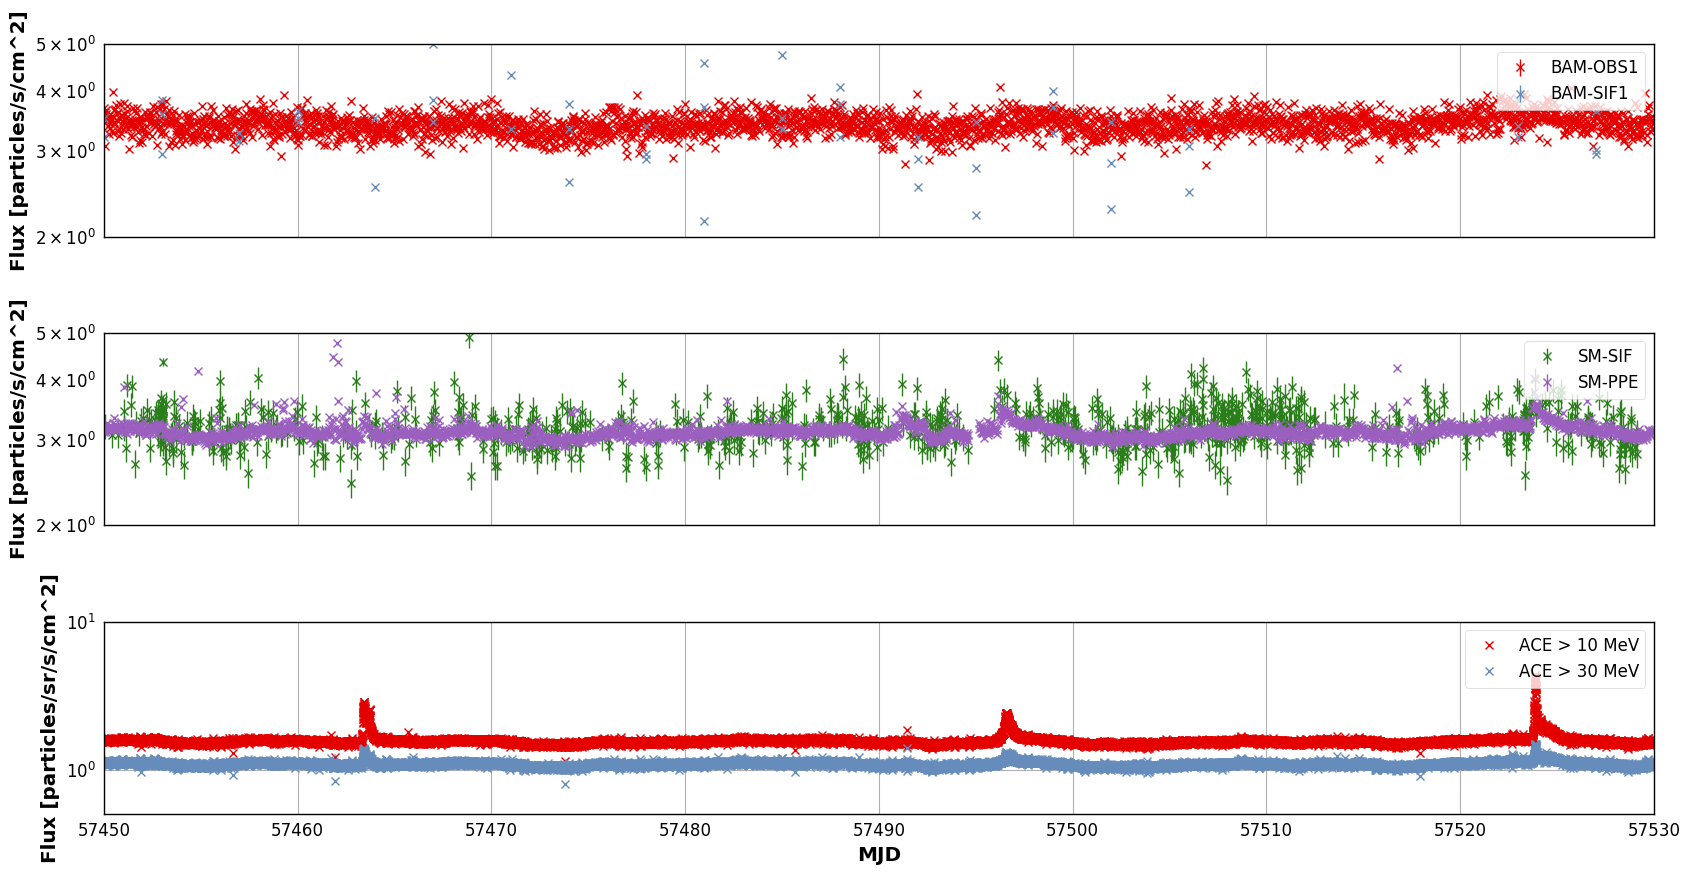

In [84]:
flareplot(57450,57530,10,ybam=(2,5),ysm=(2,5),yext=(.5,10))

Again curious to see when something is picked up or not

## 57600 - 57800

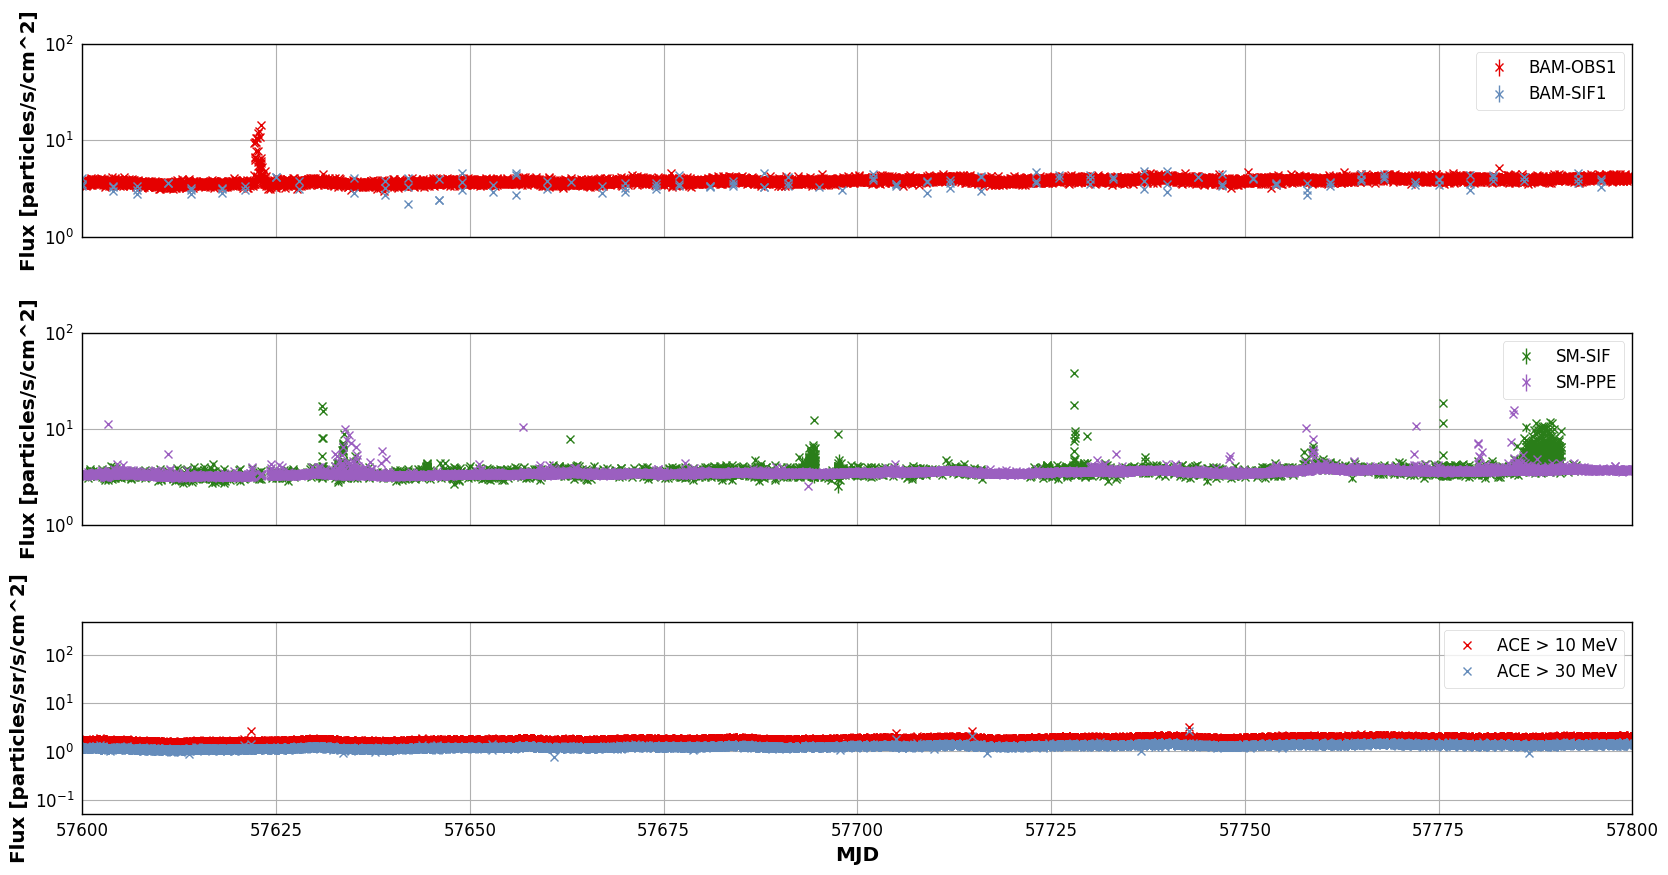

In [85]:
flareplot(57600,57800,10)

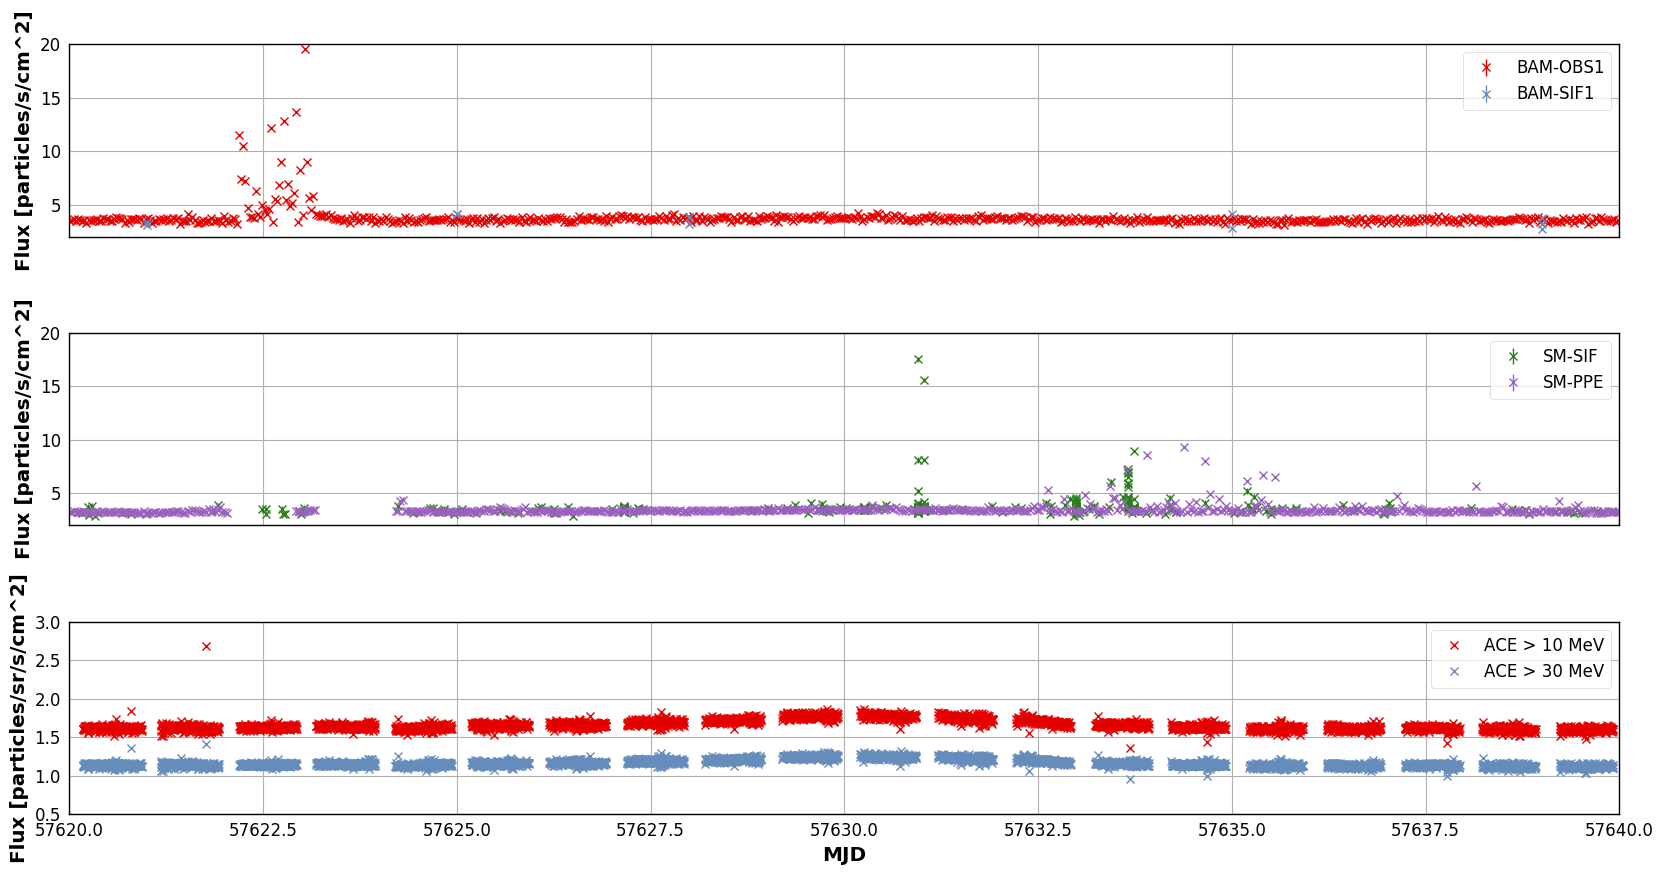

In [86]:
flareplot(57620,57640,10,ybam=(2,20),ysm=(2,20),yext=(.5,3),log=False)

Extra flare in BAM? Probably instrumental things.

## 57800 - 58000

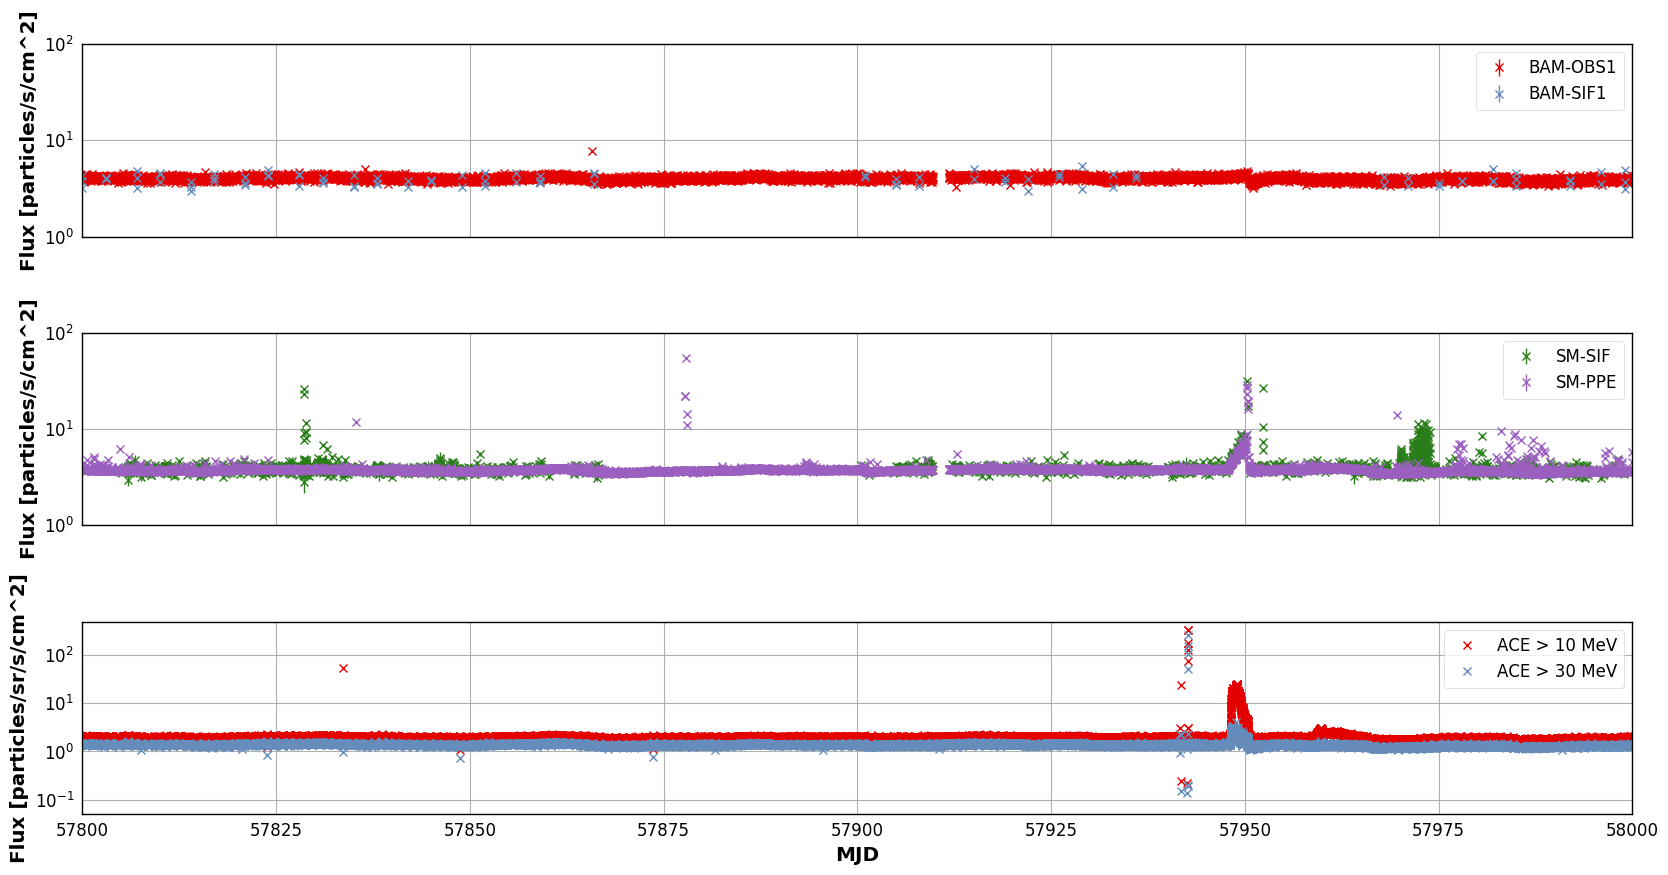

In [87]:
flareplot(57800,58000,10)

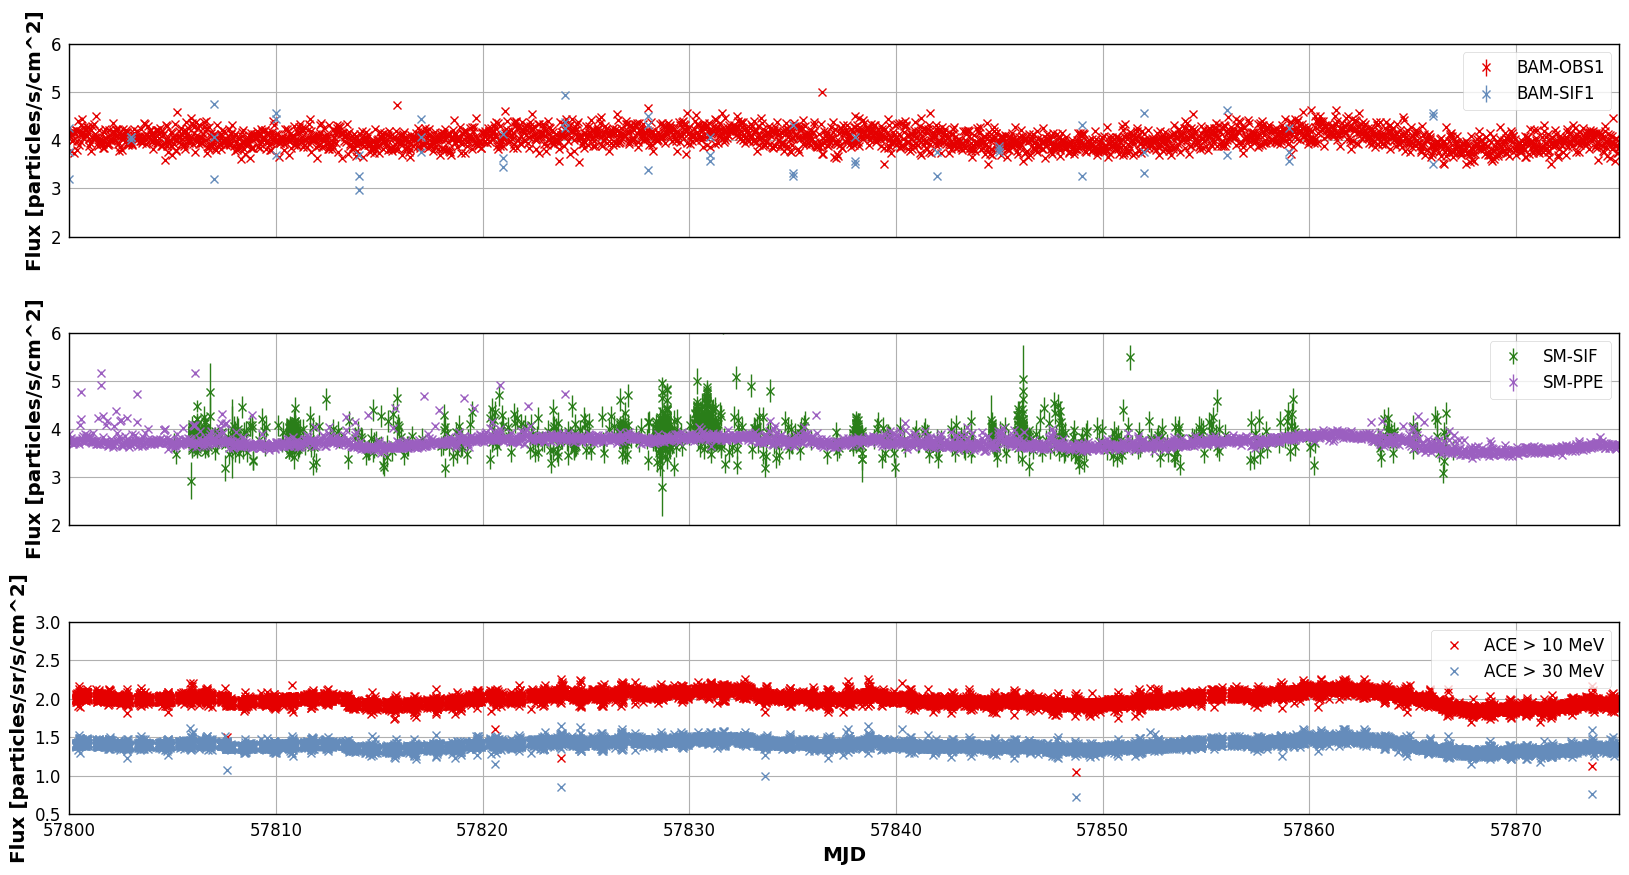

In [88]:
flareplot(57800,57875,10,ybam=(2,6),ysm=(2,6),yext=(.5,3),log=False)

Interesting here: There is some modulation from 57800 to 57875 that's perfectly matched by BAM

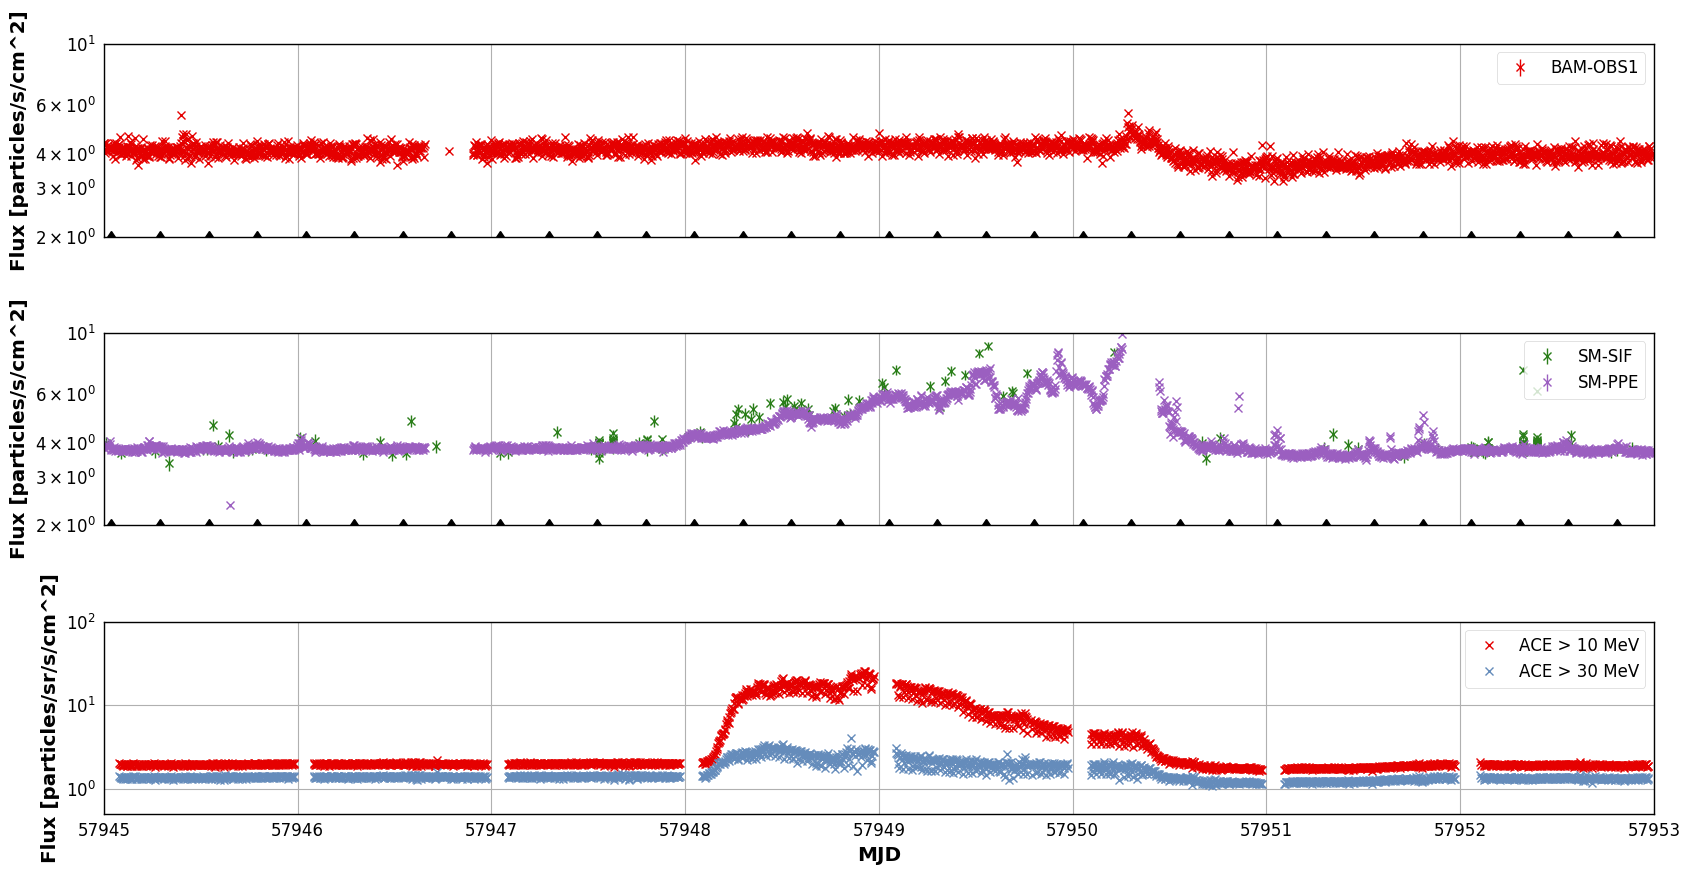

In [89]:
#flareplot(57940,57975,10,ybam=(2,10),ysm=(2,10),yext=(.5,100),log=True)
flareplot(57945,57953,1,ybam=(2,10),ysm=(2,10),yext=(.5,100),log=True,turns=spinturns)

Kink in BAM after the flare. It also looks very interesting in SM vs ACE...

## 58000 - NOW

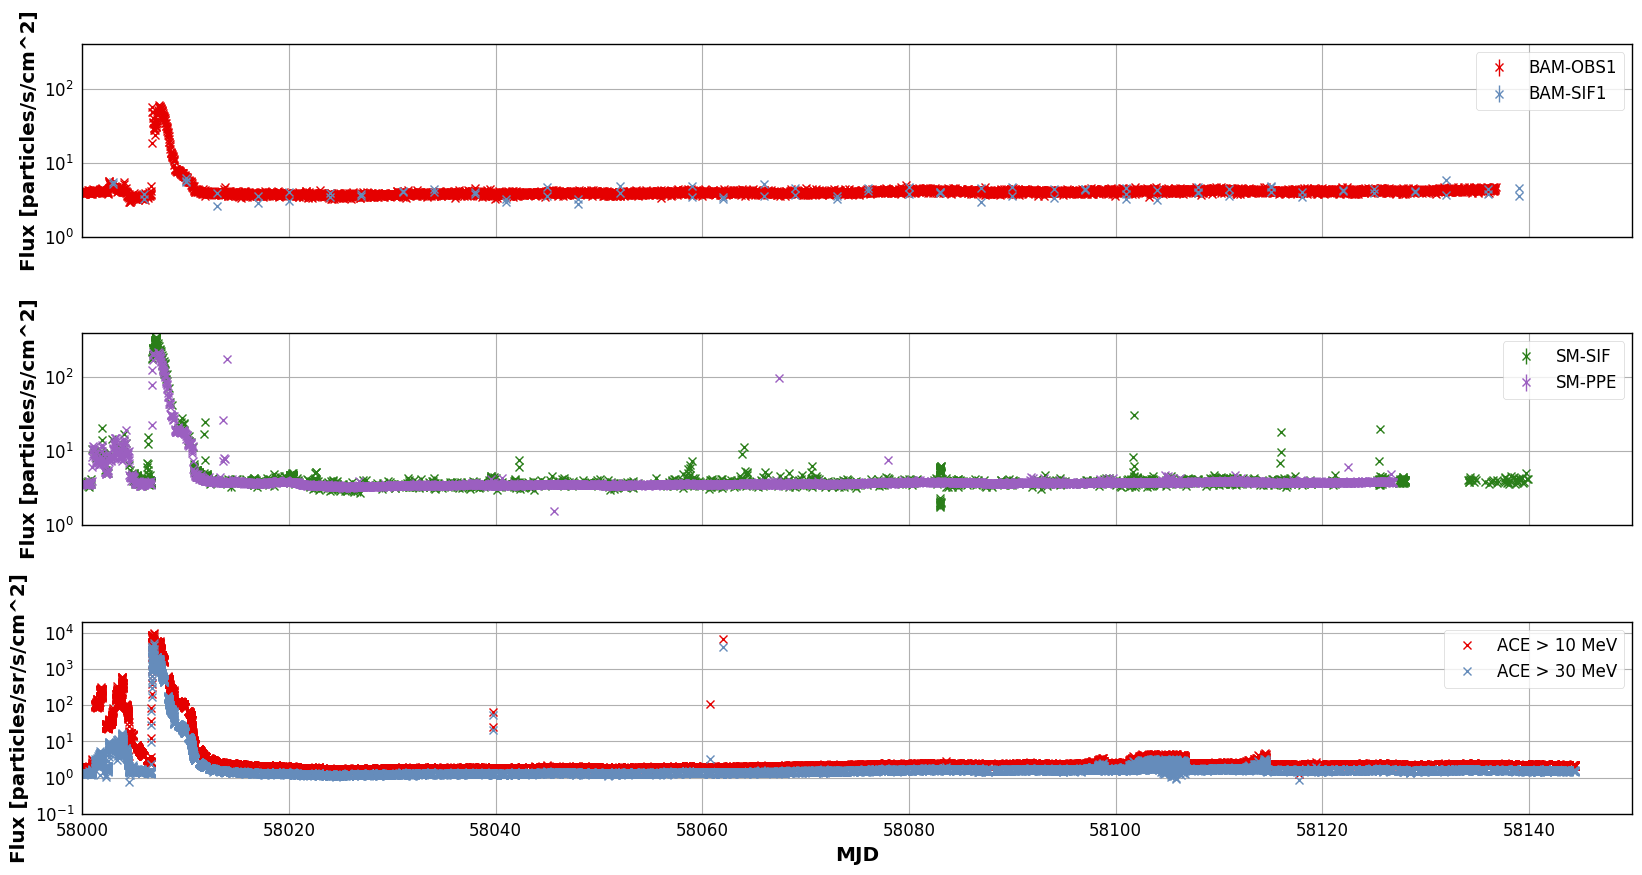

In [90]:
flareplot(58000,58150,10,ybam=(1,400),ysm=(1,400),yext=(.1,20000))

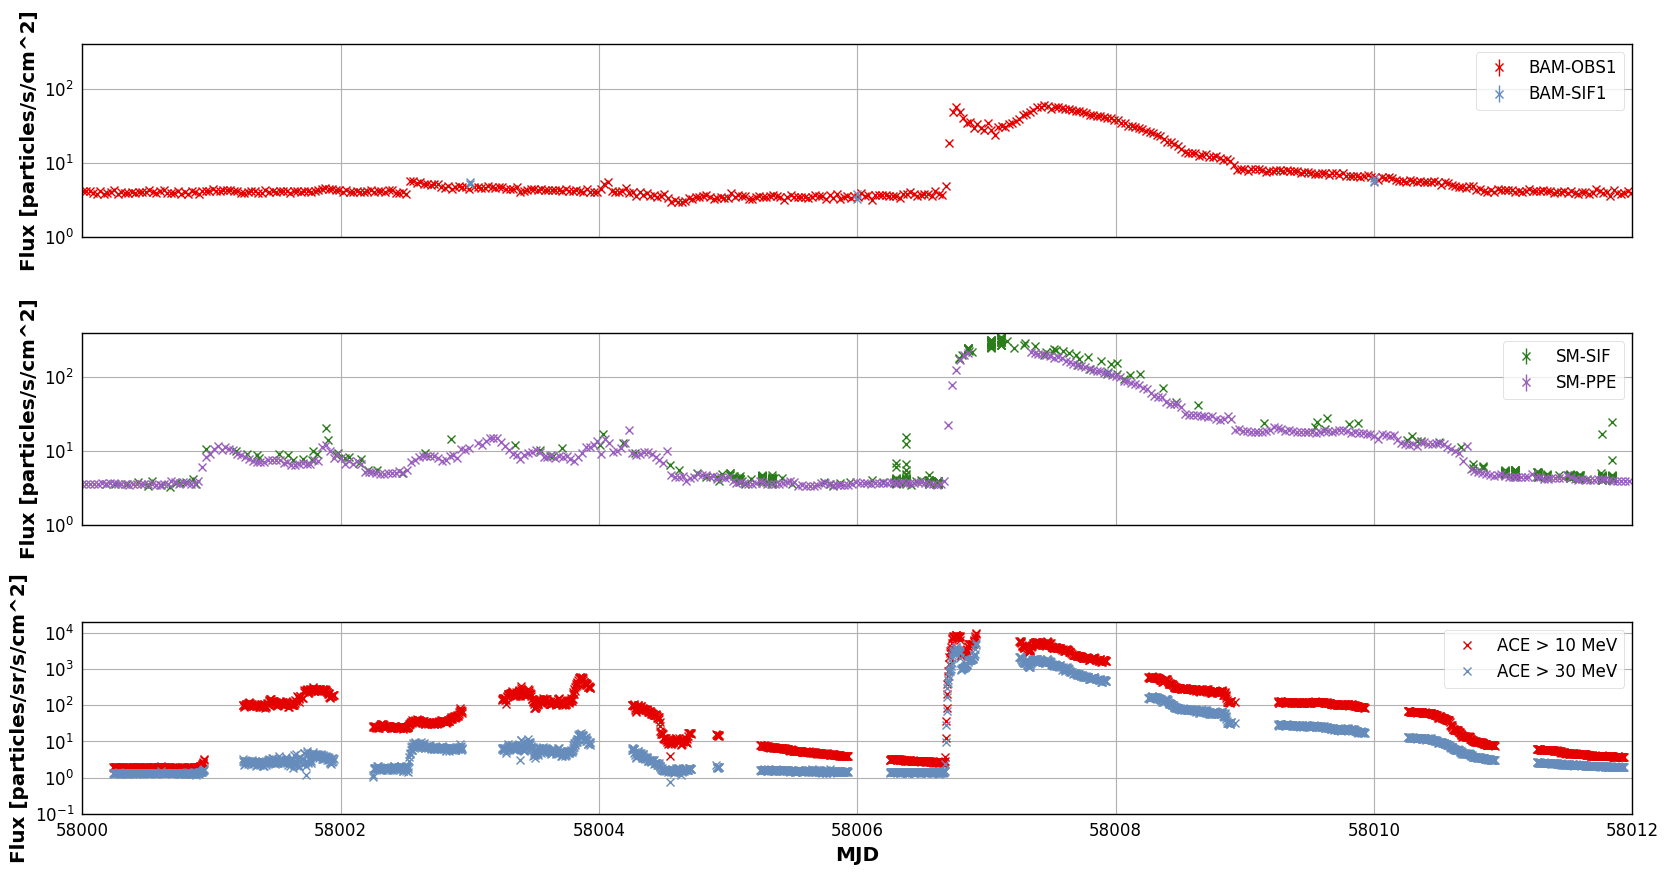

In [16]:
# September 2017
flareplot(58000,58012,10,ybam=(1,400),ysm=(1,400),yext=(.1,20000))

Very interesting precursor. BAM is totally overwhelmed during the flare proper, but we do see some of the kinks in the ACE data as well.

# Frequency modulations

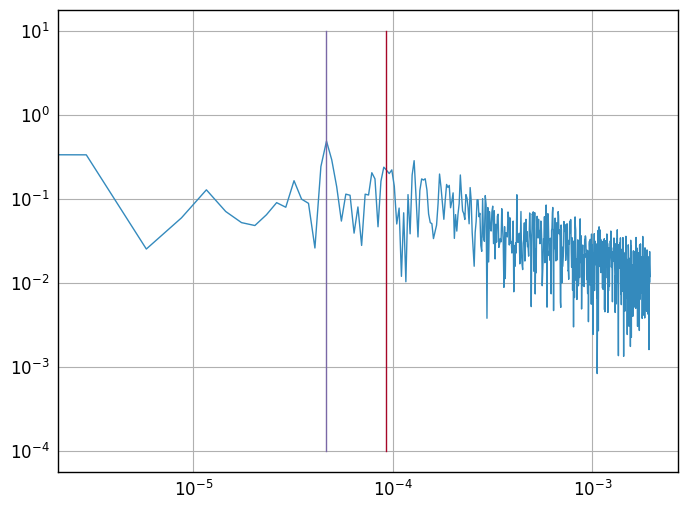

In [92]:
# what do we get from an fft of these fluxes?

from scipy.fftpack import fft

#tstart,tstop = (57930,57945) # quiet period
tstart,tstop = (57632,57636) # strong stray light modulation

#t,f,err = MJD_cutout(t_B1_full,f_B1_full,err_B1_full,tstart,tstop)
t,f,err = MJD_cutout(t_P,f_P,err_P,tstart,tstop)


N = len(t)

# sample spacing

T = (t[1]-t[0]) * 86400 # MJD -> Seconds

y_fft = fft(f)
x_fft = np.linspace(0,1/(2*T), N//2)

plt.plot(x_fft, 2/N * np.abs(y_fft[0:N//2]))

plt.xscale("log")
plt.yscale("log")

plt.plot(np.ones(500)/(6*3600), np.linspace(1e-4,10,500)) # should be 6 hours
plt.plot(np.ones(500)/(3*3600), np.linspace(1e-4,10,500)) # should be 3 hours

# Orbits

In [12]:
orbdat = fits.getdata('../datasets/Position/CorotatingOrbit.fits')

T = orbdat["TIME"]
x = orbdat["X"]
y = orbdat["Y"]
z = orbdat["Z"]

NameError: name 't_S' is not defined

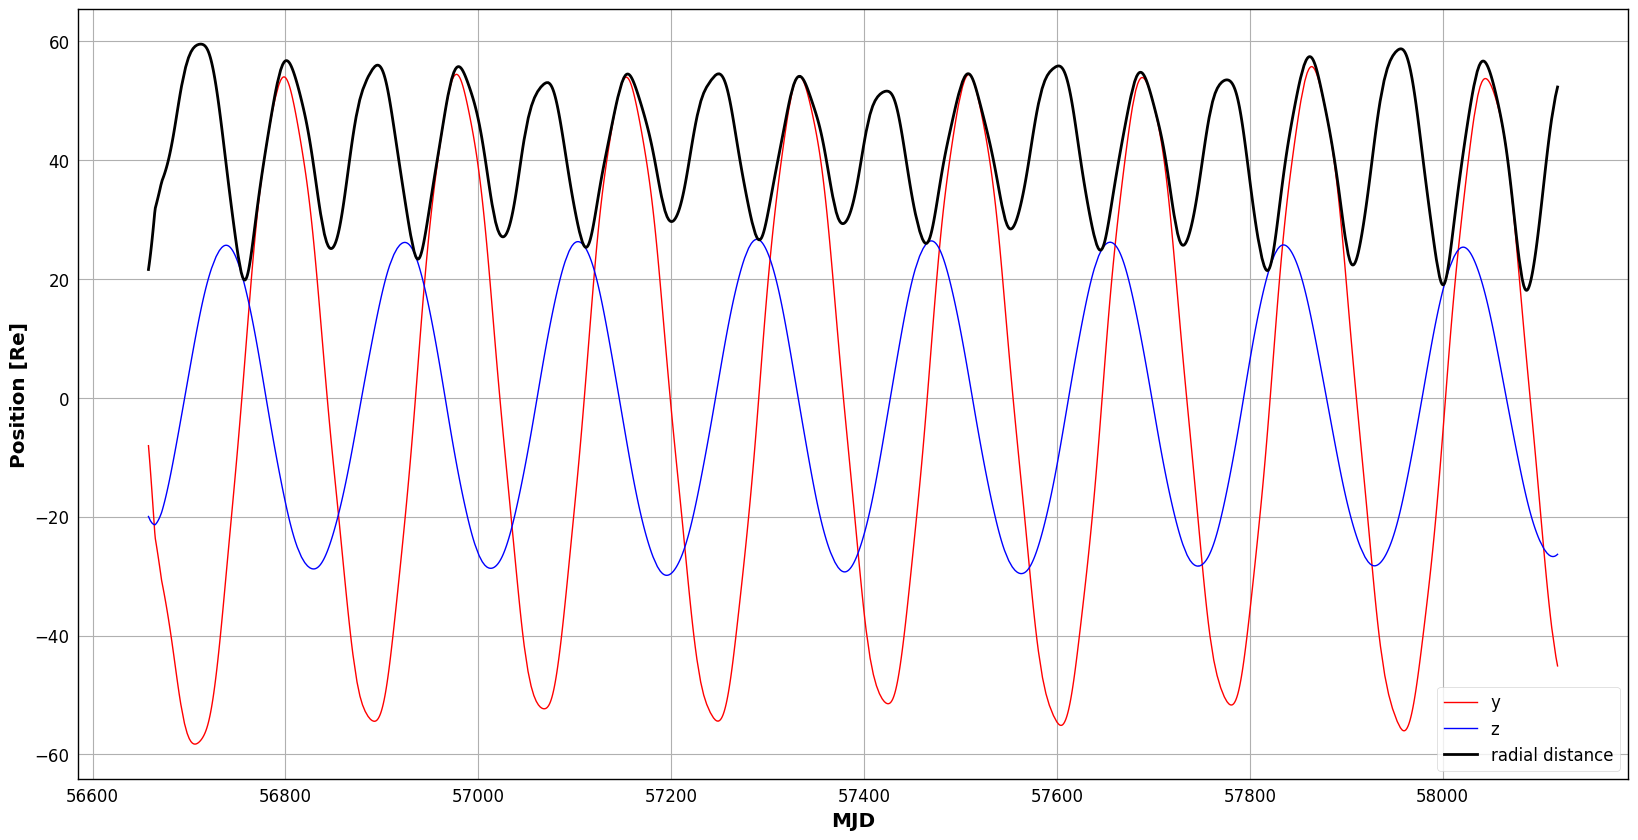

In [19]:
plt.plot(T,y/6371e3,color='r',label='y')
plt.plot(T,z/6371e3,color='b',label='z')
plt.plot(T,np.sqrt(y**2+z**2)/6371e3,color='k',label='radial distance',linewidth=2)

plt.legend(loc='lower right')
plt.xlabel("MJD")
plt.ylabel("Position [Re]")
plt.gcf().set_size_inches(20,10)
plt.xlim(min(OBMT_apyTime(t_S).mjd),max(OBMT_apyTime(t_S).mjd))

In [120]:
def meanpos(T,y,z,tstart,tstop):
    trange = np.logical_and(T>=tstart, T<=tstop)
    
    return np.mean(y[trange])/6371e3, np.mean(z[trange]/6371e3)

meanpos(T,y,z,57380, 57385)

(-6.74565905782947, -29.142011045973998)

# Some closer looks

In [98]:
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat')
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV2_ROW1.dat')

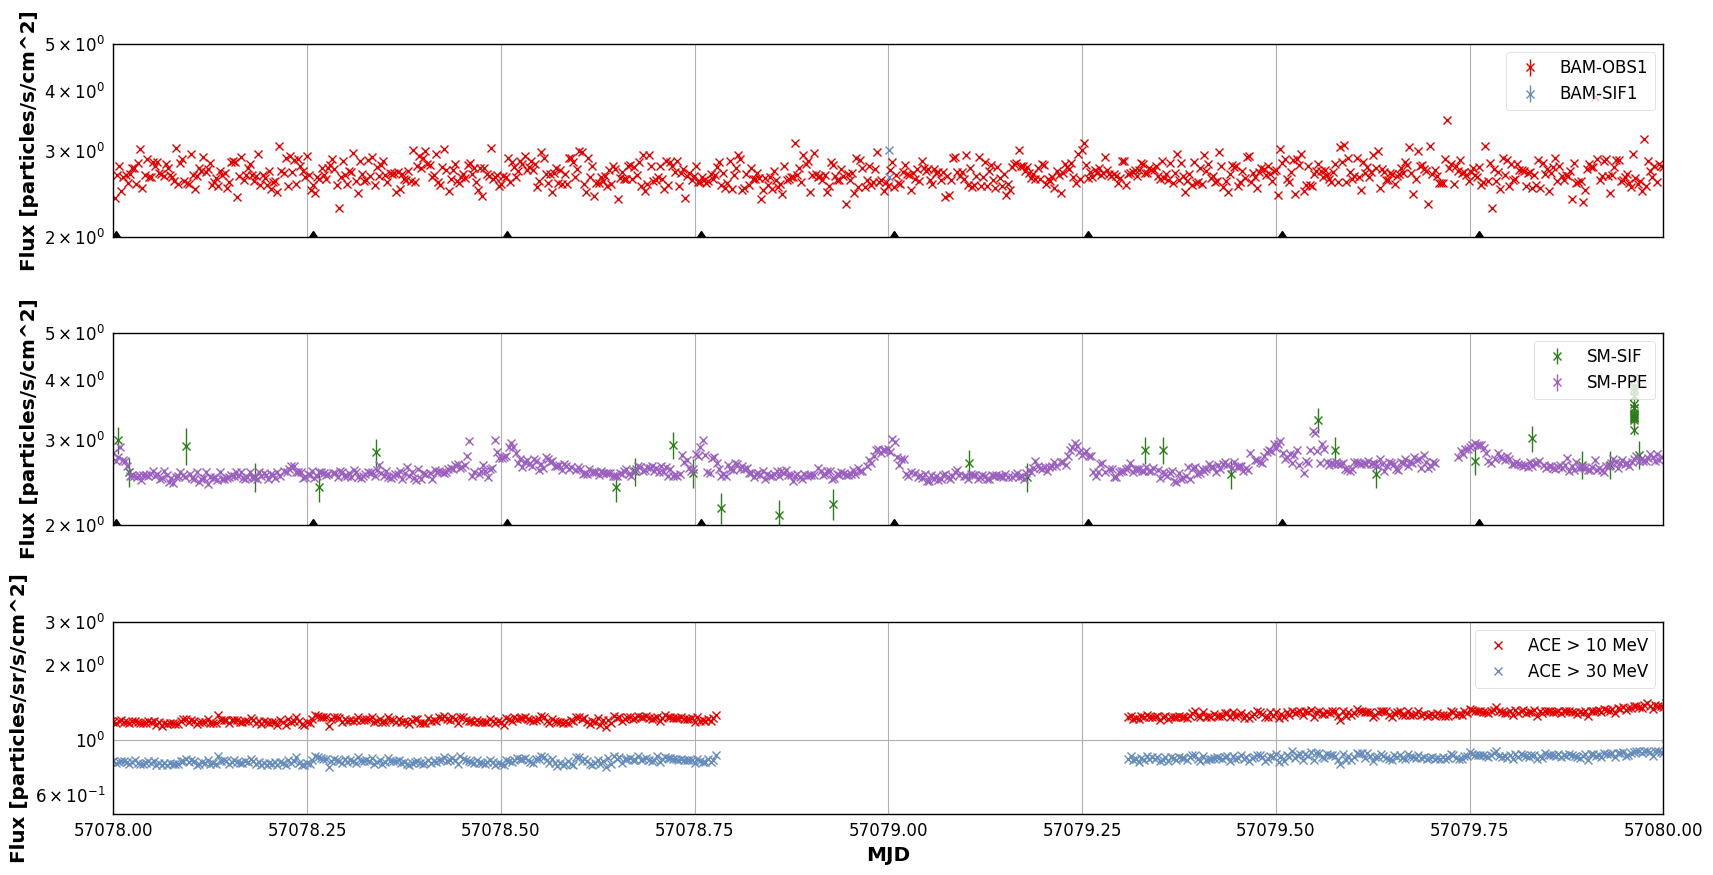

In [36]:
# Clear signs of modulation in the first two
#flareplot(56751,56758,1,ybam=(2,5),ysm=(2,5),yext=(.5,5),log=True,turns=spinturns)
#flareplot(56765,56770,1,ybam=(2,7),ysm=(2,7),yext=(.5,100),log=True,turns=spinturns)
#flareplot(56783.5,56786.5,1,ybam=(2,5),ysm=(2,5),yext=(.5,5),log=True,turns=spinturns)


# Strongly modulated and timing difference in first; second also has some cuts
#flareplot(56813,56818,1,ybam=(2,4),ysm=(2,4),yext=(.5,2),log=True,turns=spinturns)
#flareplot(56818,56828,1,ybam=(2,4),ysm=(2,4),yext=(.5,2),log=True,turns=spinturns)


# Nothing major
#flareplot(56901.5,56910,1,ybam=(2,10),ysm=(2,10),yext=(.5,150),log=True,turns=spinturns)
#flareplot(56910.5,56913.5,1,ybam=(2,20),ysm=(2,20),yext=(.5,150),log=True,turns=spinturns)


# strong modulation, different timing?
#flareplot(57012,57016,1,ybam=(2,10),ysm=(2,10),yext=(.5,10),log=True,turns=spinturns)


# very strong modulation
#flareplot(57049,57056,1,ybam=(2,5),ysm=(2,5),yext=(.5,5),log=True,turns=spinturns)
#flareplot(57074,57085,1,ybam=(2,5),ysm=(2,5),yext=(.5,3),log=True,turns=spinturns)
flareplot(57078,57080,1,ybam=(2,5),ysm=(2,5),yext=(.5,3),log=True,turns=spinturns) # to look for spin-enhancements


# some modulation in 2 and 3, the entire flare looks different
#flareplot(57191,57194,1,ybam=(2,6),ysm=(2,6),yext=(.5,70),log=True,turns=spinturns)
#flareplot(57194,57198.5,1,ybam=(2,15),ysm=(2,15),yext=(.5,700),log=True,turns=spinturns)
#flareplot(57198.5,57206,1,ybam=(2,6),ysm=(2,6),yext=(.5,70),log=True,turns=spinturns)


# weak modulation
#flareplot(57285,57287.5,1,ybam=(2,10),ysm=(2,10),yext=(.5,10),log=True,turns=spinturns)
#flareplot(57295,57300,1,ybam=(2,4),ysm=(2,4),yext=(.5,5),log=True,turns=spinturns)


# nothing visible
#flareplot(57324,57328,1,ybam=(2,10),ysm=(2,10),yext=(.5,150),log=True,turns=spinturns)


# very noticeable modulation
#flareplot(57380,57395,1,ybam=(2,6),ysm=(2,6),yext=(.5,70),log=True,turns=spinturns)


# these flares are hardly detected
#flareplot(57463,57465,1,ybam=(2,6),ysm=(2,6),yext=(.5,5),log=True,turns=spinturns)
#flareplot(57495,57500,1,ybam=(2,6),ysm=(2,6),yext=(.5,5),log=True,turns=spinturns)
#flareplot(57523.5,57526,1,ybam=(2,6),ysm=(2,6),yext=(.5,5),log=True,turns=spinturns)

# No modulation? The flare looks very different in SM
#flareplot(57948,57951,1,ybam=(2,50),ysm=(2,50),yext=(.5,70),log=True,turns=spinturns)

# first: Some modulaiton, especially at low flux
# second: Some noticeable when zooming in (in y)
#flareplot(58000,58006,1,ybam=(2,30),ysm=(2,30),yext=(.5,1000),log=True,turns=spinturns)
#flareplot(58006,58012,1,ybam=(2,400),ysm=(2,400),yext=(.5,20000),log=True,turns=spinturns)

# Dummy period with strong stray light
#flareplot(57679,57682,1,ybam=(3,4),ysm=(3,4),yext=(.5,3),log=False,turns=spinturns)


One interesting thing: The modulation seems to generally show up whenever we're at the turnaround, in BOTH SM1 and SM2!

Spin phase 180 degrees is whenever the FPA is facing the sun